In [1]:
# Version_v2
# For ipython notebook adapted for different systems (some not equilibrated yet and/or crashed before ending) use
# old NewVersion4.ipynb or NewVersion4_corrected.ipynb from "scripts" repository

In [ ]:
'''
Problematic systems to leave out from plots (for plots with all systems see folder ") => check simulations!!
- s11 w2000 (equilibrated but unstable)
- s11 w2000 (equilibrated but unstable)
- s22 w1000 (equilibrated but unstable)
[- s22 w2000 => check simulation and decide]
- s22 w4000 (equilibrated but strange at the end)
- s37 w3000
- s37 w10000
- s44 w7000 (not equilibrated)
- s44 w8000 (not equilibrated)
- s44 w9000 (equilibrated but needs more time??)
- s44 w10000

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
from scipy import odr
from matplotlib.font_manager import FontProperties
from fractions import Fraction
from scipy.interpolate import interp1d
import os
from Results_Module import *

In [3]:
# Delete this cell: only for testing equilibrated systems
#print angles_w[z]
endpoint(angles_w[z])

NameError: name 'angles_w' is not defined

In [11]:
#ResultsFolder = '/Volumes/UNI/radial_densmaps_Version_v2'
ResultsFolder = '/Users/burbol2/GitHub/LineTensionPackage/Results_CAnglesScript/' #MacBook Pro
ResultsFolder = '/Users/eixeres/Dropbox/GitHub/LineTensionPackage/Results_CAnglesScript' #iMac
FolderForPlots = ResultsFolder + "/plots"

In [5]:
percentages = [0, 11, 22, 33, 37, 44, 50]
SAMs=[0, 11, 22, 33, 37, 44] #percentages without complete wetting
Waters = {}

#Finished "good" simulations
Waters[0]=[1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000, 10000]
Waters[11]=Waters[0]
Waters[22]=Waters[0]
Waters[33]=Waters[0]
Waters[37]=[1000, 2000, 4000, 5000, 6500, 7000, 8000, 9000]
Waters[44]=[1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000]

In [6]:
# In the following dictionaries we will save the raw input data (mic. contact angle & base radius)

angles_w = {}
radii_w = {}

angles_m = {}
radii_m = {}

angles_s = {}
radii_s = {}

# In the following dictionaries we will save the results for the cos(theta) and 1/r_base, and their errorbars 
# (theta refers to the mac. contact angle)
# We will call them the "results-dictionaries"

theta_w = {}  # cos(theta)
rbase_w = {}  # 1/r_base
errortheta_w = {}
error_rbase_w = {}
equil_theta_w = {}
equil_rbase_w = {}

theta_m = {}
rbase_m = {}
errortheta_m = {}
error_rbase_m = {}
equil_theta_m = {}
equil_rbase_m = {}

theta_s = {}
rbase_s = {}
errortheta_s = {}
error_rbase_s = {}
equil_theta_s = {}
equil_rbase_s = {}


# For each surface we will store 10 results corresponding to the 10 droplets in each system. This means that in every 
# entry of the "results-dictionaries" we will store a list of 10 elements. Thus, now we store in them lists with 10 zeros. 

for system in percentages:
    
    theta_w[system] = []
    rbase_w[system] = []
    errortheta_w[system] = []
    error_rbase_w[system] = []
    equil_theta_w[system] = []
    equil_rbase_w[system] = []
    
    theta_m[system] = []
    rbase_m[system] = []
    errortheta_m[system] = []
    error_rbase_m[system] = []
    equil_theta_m[system] = []
    equil_rbase_m[system] = []
    
    theta_s[system] = []
    rbase_s[system] = []
    errortheta_s[system] = []
    error_rbase_s[system] = []
    equil_theta_s[system] = []
    equil_rbase_s[system] = []

In [7]:
# We create an array named "t" with the time values. We use the length of the longest simulation.

maxlength=200 #maximum length in ns
t = np.zeros(2*maxlength)
i=0
for d in frange(0, maxlength, 0.5,closed=0):
    t[i] = d
    i = i + 1

In [12]:
# Read files and save contant angles and radii in dictionaries:
# For interface at first Water density peak in "angles_w" and "radii_w"
# For interface at highest SAM carbon in "angles_s" and "radii_s"
# For interface at GDS in "angles_m" and "radii_m"

# Each dictionary consists of a set of "key: value" pairs, each one corresponding to a different system. The keys are (also) a pair of numbers "b, c".
# "b" refers to the OH-coverage percentage of the SAM, and "c" to the number of water molecules of the droplet. 
# For example, the key "11, 1000" refers to the system with a surface with 11% OH-coverage, and a droplet with 1000 water molecules. 
# The value corresponding to each key is an array with the 400 calculated angles/base radii (1 value each 0.5ns), that belong to that system. For example: "radii[(11, 3000)]" would give back
# the array with the 40 calculated values of the base radii corresponding to the system with a surface with 11% OH-coverage, and a droplet with 3000 water molecules.
os.chdir(ResultsFolder)
for b in SAMs:
    theta_data_w, rbase_data_w = np.loadtxt('Contact_Angles2_WaterPeak_s'+str(b)+'.txt', skiprows=2, usecols = (0,1),unpack=True)
    theta_data_m, rbase_data_m = np.loadtxt('Contact_Angles2_GDS_s'+str(b)+'.txt', skiprows=2, usecols = (0,1),unpack=True)
    theta_data_s, rbase_data_s = np.loadtxt('Contact_Angles2_SAM_last_C_atom_s'+str(b)+'.txt', skiprows=2, usecols = (0,1),unpack=True)
    k = 0
    for c in Waters[0]:
        z = b, c        
        i=k*(2*maxlength)
        j=(k+1)*(2*maxlength)
        #print "z=", z, "i=", i, "j=", j
        
        # Interface at first Water density peak
        m = 0
        th_w = [0] *(2*maxlength)
        r_w = [0] *(2*maxlength)        
        for l in range(i,j):
            th_w[m]=theta_data_w[l]
            r_w[m]=rbase_data_w[l]
            m = m +1
        angles_w[z] = th_w
        radii_w[z] = r_w
        
        # Interface at GDS
        th_m = [0] *(2*maxlength)
        r_m = [0] *(2*maxlength)
        m = 0
        for l in range(i,j):
            th_m[m]=theta_data_m[l]
            r_m[m]=rbase_data_m[l]
            m = m +1
        angles_m[z] = th_m
        radii_m[z] = r_m
        
        # Interface at highest SAM carbon
        th_s = [0] *(2*maxlength)
        r_s = [0] *(2*maxlength)
        m = 0
        for l in range(i,j):
            th_s[m]=theta_data_s[l]
            r_s[m]=rbase_data_s[l]
            m = m +1
        angles_s[z] = th_s
        radii_s[z] = r_s

        k=k+1

In [13]:
os.chdir(FolderForPlots)

In [14]:
# Print some values as a test
z=37,9000
w=39
print angles_w[z][w]
print angles_m[z][w]
print angles_s[z][w]
print radii_w[z][w]
print radii_m[z][w]
print radii_s[z][w]

56.3543523634
55.2461037398
58.0522825123
6.51686285833
6.45314281403
6.64251574709


In [15]:
'''
Documentation on adjusting the subplots:
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots

********************************************************************
For adjusting the legend box:

Padding and spacing between various elements use following
keywords parameters. These values are measure in font-size
units. E.g., a fontsize of 10 points and a handlelength=5
implies a handlelength of 50 points.  Values from rcParams
will be used if None.

=====================================================================
Keyword       |    Description
=====================================================================
borderpad          the fractional whitespace inside the legend border
labelspacing       the vertical space between the legend entries
handlelength       the length of the legend handles
handletextpad      the pad between the legend handle and text
borderaxespad      the pad between the axes and legend border
columnspacing      the spacing between columns
'''

'\nDocumentation on adjusting the subplots:\nsubplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)\n\nleft  = 0.125  # the left side of the subplots of the figure\nright = 0.9    # the right side of the subplots of the figure\nbottom = 0.1   # the bottom of the subplots of the figure\ntop = 0.9      # the top of the subplots of the figure\nwspace = 0.2   # the amount of width reserved for blank space between subplots\nhspace = 0.2   # the amount of height reserved for white space between subplots\n\n********************************************************************\nFor adjusting the legend box:\n\nPadding and spacing between various elements use following\nkeywords parameters. These values are measure in font-size\nunits. E.g., a fontsize of 10 points and a handlelength=5\nimplies a handlelength of 50 points.  Values from rcParams\nwill be used if None.\n\n=====================================================================\nKeyword       |    Desc

In [16]:
rcParams['text.usetex'] = True
matplotlib.rcParams['legend.markerscale'] = 0
matplotlib.rcParams['legend.handletextpad'] = 0.1
matplotlib.rcParams['legend.markerscale'] = 2 
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['font.family'] = 'Times New Roman Bold' 
pyplot.rcParams.update({'legend.labelspacing':0.25})

#Direct input 
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 


'''
#COPIED FROM INTERNET AND USED IN LAST CELL:
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 
'''

'\n#COPIED FROM INTERNET AND USED IN LAST CELL:\nplt.rcParams[\'text.latex.preamble\']=[r"\\usepackage{lmodern}"]\n#Options\nparams = {\'text.usetex\' : True,\n          \'font.size\' : 11,\n          \'font.family\' : \'lmodern\',\n          \'text.latex.unicode\': True,\n          }\nplt.rcParams.update(params) \n'

In [17]:
# Labels for plots
anglelabel = 'Contact Angle [deg]'
radiuslabel = 'Base radius [nm]'
anglename = "theta"
radiusname = "Rbase"

for SAM  0 % and  1000  molecules:
num of good intervals= 78
for SAM  0 % and  2000  molecules:
num of good intervals= 124
for SAM  0 % and  3000  molecules:
num of good intervals= 136
for SAM  0 % and  4000  molecules:
num of good intervals= 198
for SAM  0 % and  5000  molecules:
num of good intervals= 113
for SAM  0 % and  6500  molecules:
num of good intervals= 118
for SAM  0 % and  7000  molecules:
num of good intervals= 109
for SAM  0 % and  8000  molecules:
num of good intervals= 56
for SAM  0 % and  9000  molecules:
num of good intervals= 51
for SAM  0 % and  10000  molecules:
num of good intervals= 137


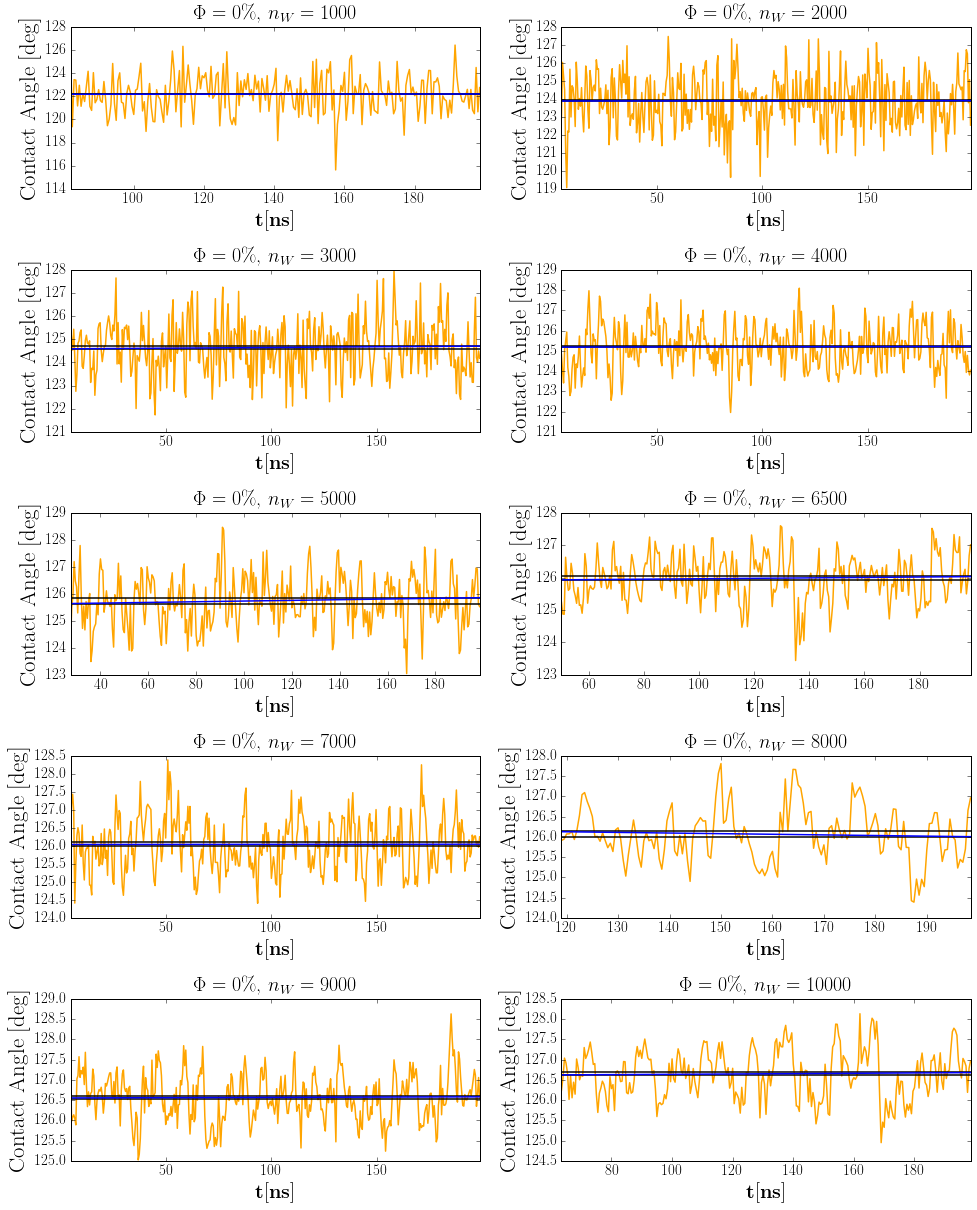

for SAM  0 % and  1000  molecules:
num of good intervals= 78
for SAM  0 % and  2000  molecules:
num of good intervals= 124
for SAM  0 % and  3000  molecules:
num of good intervals= 136
for SAM  0 % and  4000  molecules:
num of good intervals= 198
for SAM  0 % and  5000  molecules:
num of good intervals= 113
for SAM  0 % and  6500  molecules:
num of good intervals= 118
for SAM  0 % and  7000  molecules:
num of good intervals= 109
for SAM  0 % and  8000  molecules:
num of good intervals= 56
for SAM  0 % and  9000  molecules:
num of good intervals= 51
for SAM  0 % and  10000  molecules:
num of good intervals= 137


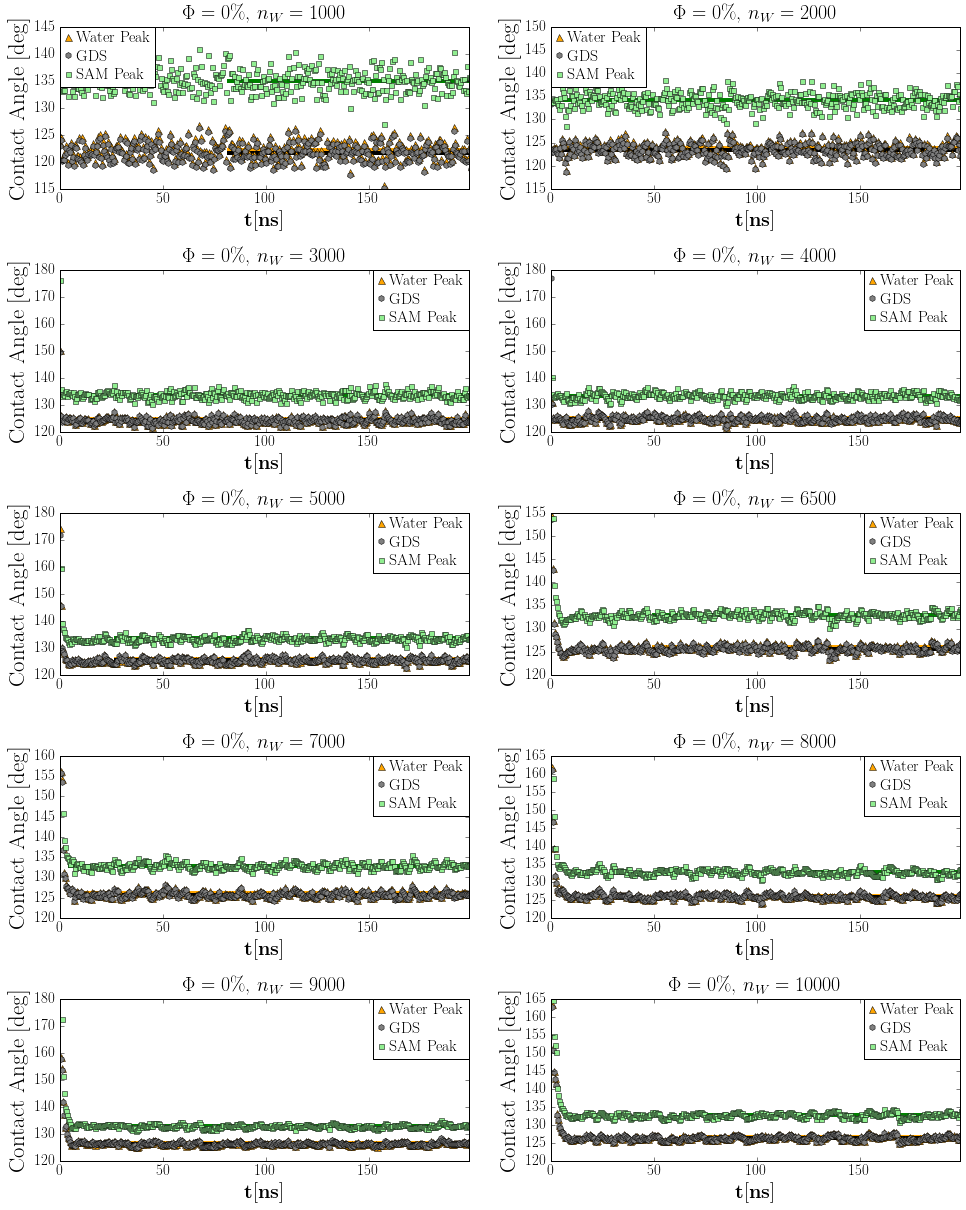

for SAM  0 % and  1000  molecules:
num of good intervals= 71
for SAM  0 % and  2000  molecules:
num of good intervals= 129
for SAM  0 % and  3000  molecules:
num of good intervals= 133
for SAM  0 % and  4000  molecules:
num of good intervals= 200
for SAM  0 % and  5000  molecules:
num of good intervals= 103
for SAM  0 % and  6500  molecules:
num of good intervals= 116
for SAM  0 % and  7000  molecules:
num of good intervals= 107
for SAM  0 % and  8000  molecules:
num of good intervals= 55
for SAM  0 % and  9000  molecules:
num of good intervals= 45
for SAM  0 % and  10000  molecules:
num of good intervals= 128


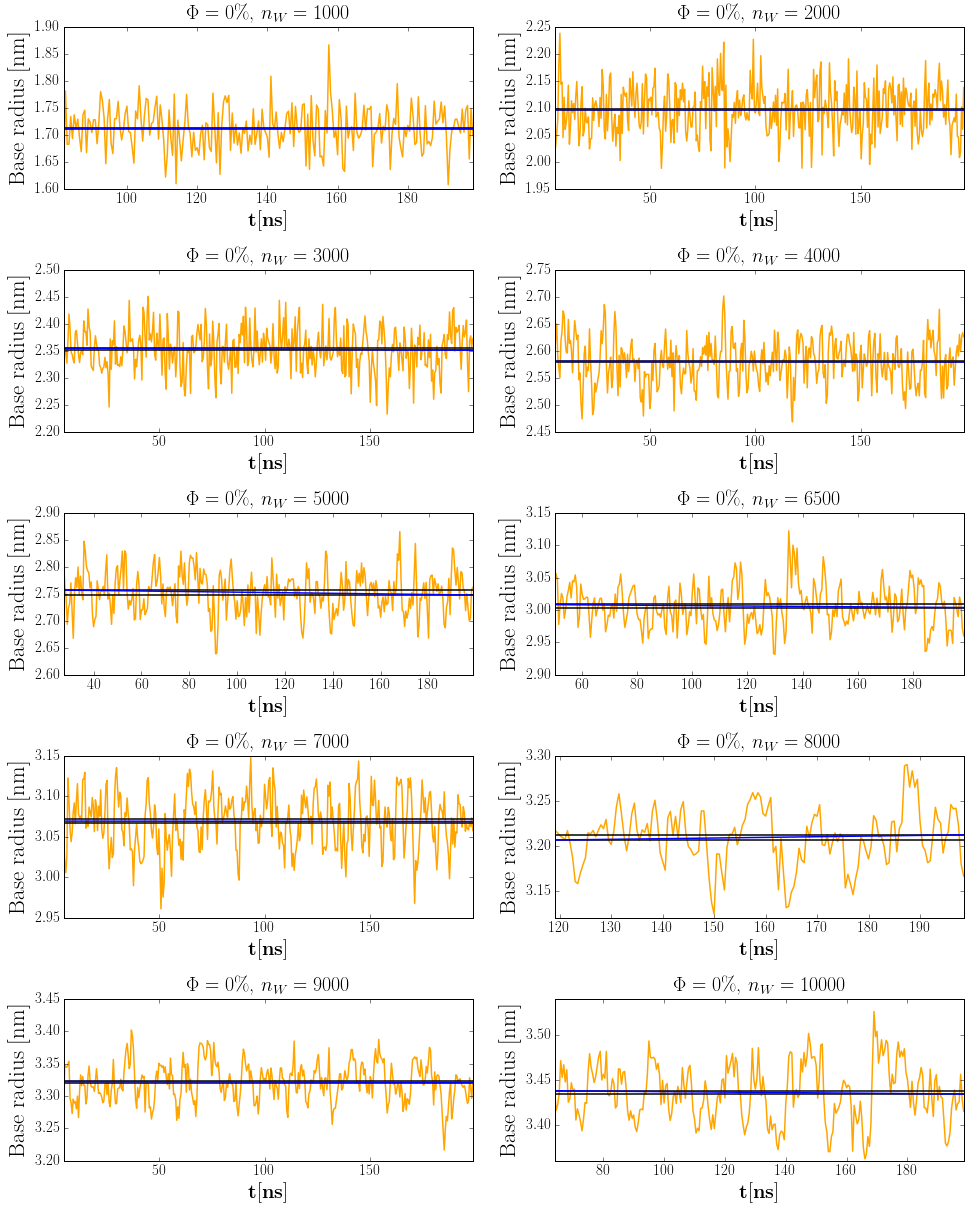

for SAM  0 % and  1000  molecules:
num of good intervals= 71
for SAM  0 % and  2000  molecules:
num of good intervals= 129
for SAM  0 % and  3000  molecules:
num of good intervals= 133
for SAM  0 % and  4000  molecules:
num of good intervals= 200
for SAM  0 % and  5000  molecules:
num of good intervals= 103
for SAM  0 % and  6500  molecules:
num of good intervals= 116
for SAM  0 % and  7000  molecules:
num of good intervals= 107
for SAM  0 % and  8000  molecules:
num of good intervals= 55
for SAM  0 % and  9000  molecules:
num of good intervals= 45
for SAM  0 % and  10000  molecules:
num of good intervals= 128


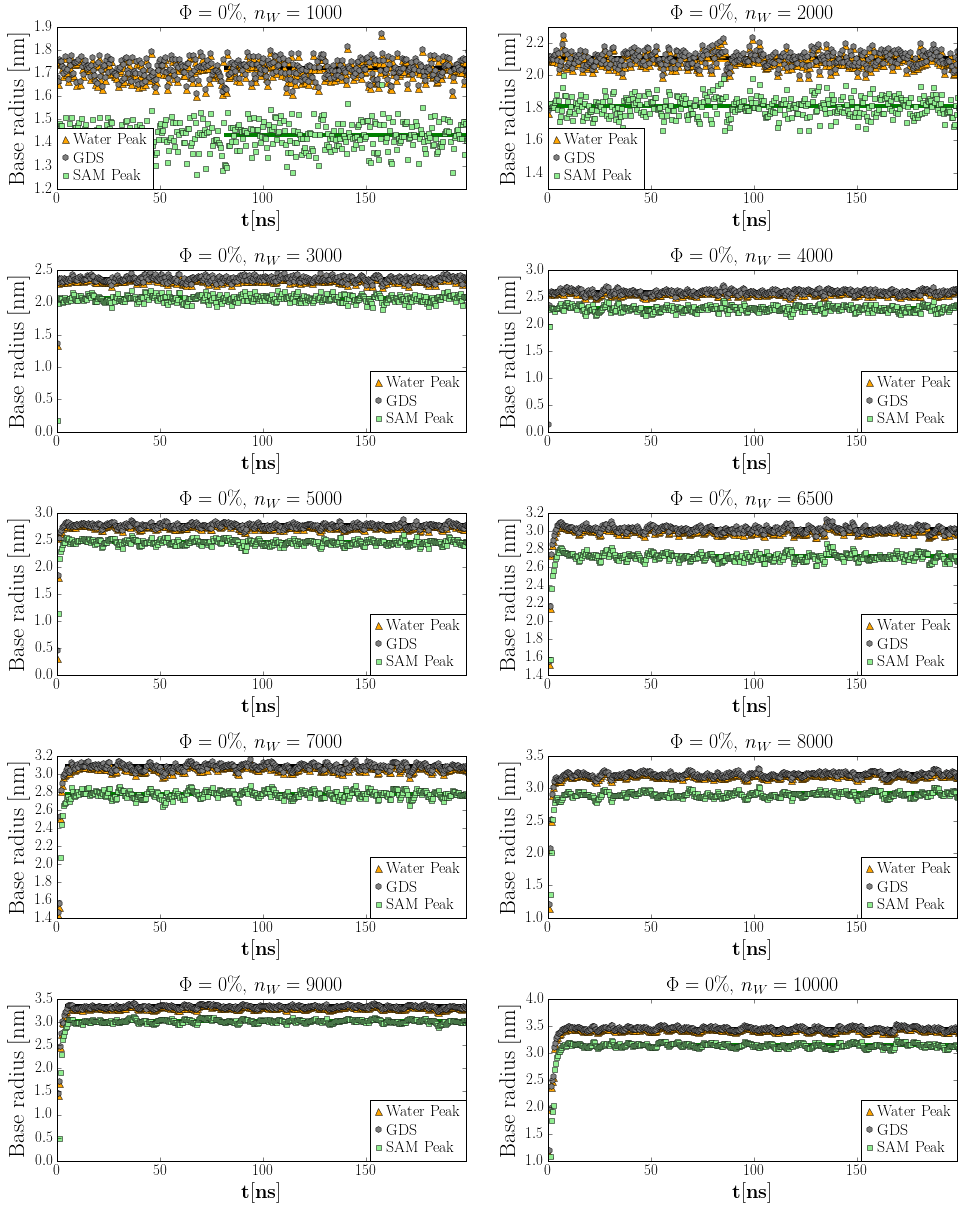

In [18]:
# Set parameters for plots of SAM with pc = 0%
pc=0

minblocksize=20 # The minimum block size is 10ns=20 points
beg = 10 # We leave out the first 5ns=10 points
blocksNum=3 #the function best_start uses also 3 blocks for averaging

Nrows = 5
Ncolumns = 2

loopvalues = Waters[0]

# Plot and analize Base Radii of equilibrated interval for GDS and SAM peak

theta_w[pc]=[] # microscopic contact angle of equilibrated system
errortheta_w[pc]=[] # error in the microscopic contact angle of equilibrated system
equil_theta_w[pc]=[] #equilibrated systems
#start_theta_w[pc]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_theta_w[pc]=[] # last t (time) of the simulation -> uncomment if needed

theta_w[pc],errortheta_w[pc],equil_theta_w[pc] = equil_results(loopvalues, angles_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, anglelabel, anglename)

# Plot and analize Contact Angles of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at MiddlePoint/GDS
errortheta_m[pc]=[]
theta_m[pc]=[]
equil_theta_m[pc]=[]
#start_theta_m[pc]=[] -> uncomment if needed
#end_theta_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
errortheta_s[pc]=[]
theta_s[pc]=[]
equil_theta_s[pc]=[]
#start_theta_s[pc]=[] -> uncomment if needed
#end_theta_s[pc]=[] -> uncomment if needed
    
theta_m[pc],errortheta_m[pc],equil_theta_m[pc],theta_s[pc],errortheta_s[pc],equil_theta_s[pc] =  whole_results(loopvalues, angles_w, angles_m, angles_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize,anglelabel, anglename)

# Plot and analize Base Radii of equilibrated interval for first water peak

error_rbase_w[pc]=[] # error in the microscopic contact angle of equilibrated system
rbase_w[pc]=[] # microscopic contact angle of equilibrated system
equil_rbase_w[pc]=[] #equilibrated systems
#start_rbase_w[b]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_rbase_w[b]=[] # last t (time) of the simulation -> uncomment if needed
    
rbase_w[pc],error_rbase_w[pc],equil_rbase_w[pc] = equil_results(loopvalues, radii_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

# Plot and analize Base Radii of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at GDS
error_rbase_m[pc]=[]
rbase_m[pc]=[]
equil_rbase_m[pc]=[]
#start_rbase_m[pc]=[] -> uncomment if needed
#end_rbase_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
error_rbase_s[pc]=[]
rbase_s[pc]=[]
equil_rbase_s[pc]=[]
#start_rbase_s[pc]=[] -> uncomment if needed
#end_rbase_s[pc]=[] -> uncomment if needed
    
rbase_m[pc],error_rbase_m[pc],equil_rbase_m[pc],rbase_s[pc],error_rbase_s[pc],equil_rbase_s[pc] =  whole_results(loopvalues, radii_w, radii_m, radii_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

for SAM  11 % and  1000  molecules:
num of good intervals= 73
for SAM  11 % and  2000  molecules:
num of good intervals= 70
for SAM  11 % and  3000  molecules:
num of good intervals= 32
for SAM  11 % and  4000  molecules:
num of good intervals= 24
for SAM  11 % and  5000  molecules:
num of good intervals= 112
for SAM  11 % and  6500  molecules:
num of good intervals= 125
for SAM  11 % and  7000  molecules:
num of good intervals= 137
for SAM  11 % and  8000  molecules:
num of good intervals= 52
for SAM  11 % and  9000  molecules:
num of good intervals= 53
for SAM  11 % and  10000  molecules:
num of good intervals= 191


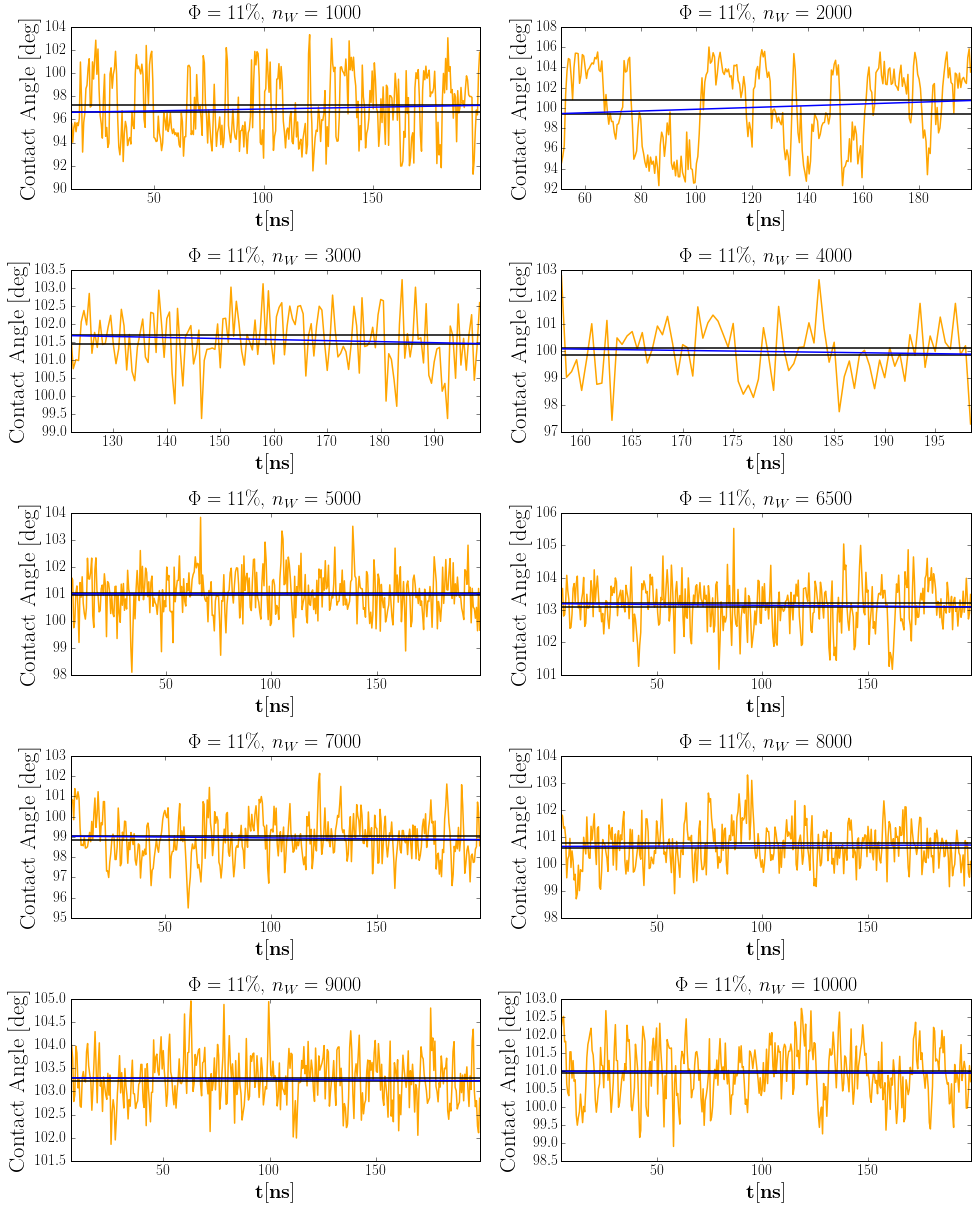

for SAM  11 % and  1000  molecules:
num of good intervals= 73
for SAM  11 % and  2000  molecules:
num of good intervals= 70
for SAM  11 % and  3000  molecules:
num of good intervals= 32
for SAM  11 % and  4000  molecules:
num of good intervals= 24
for SAM  11 % and  5000  molecules:
num of good intervals= 112
for SAM  11 % and  6500  molecules:
num of good intervals= 125
for SAM  11 % and  7000  molecules:
num of good intervals= 137
for SAM  11 % and  8000  molecules:
num of good intervals= 52
for SAM  11 % and  9000  molecules:
num of good intervals= 53
for SAM  11 % and  10000  molecules:
num of good intervals= 191


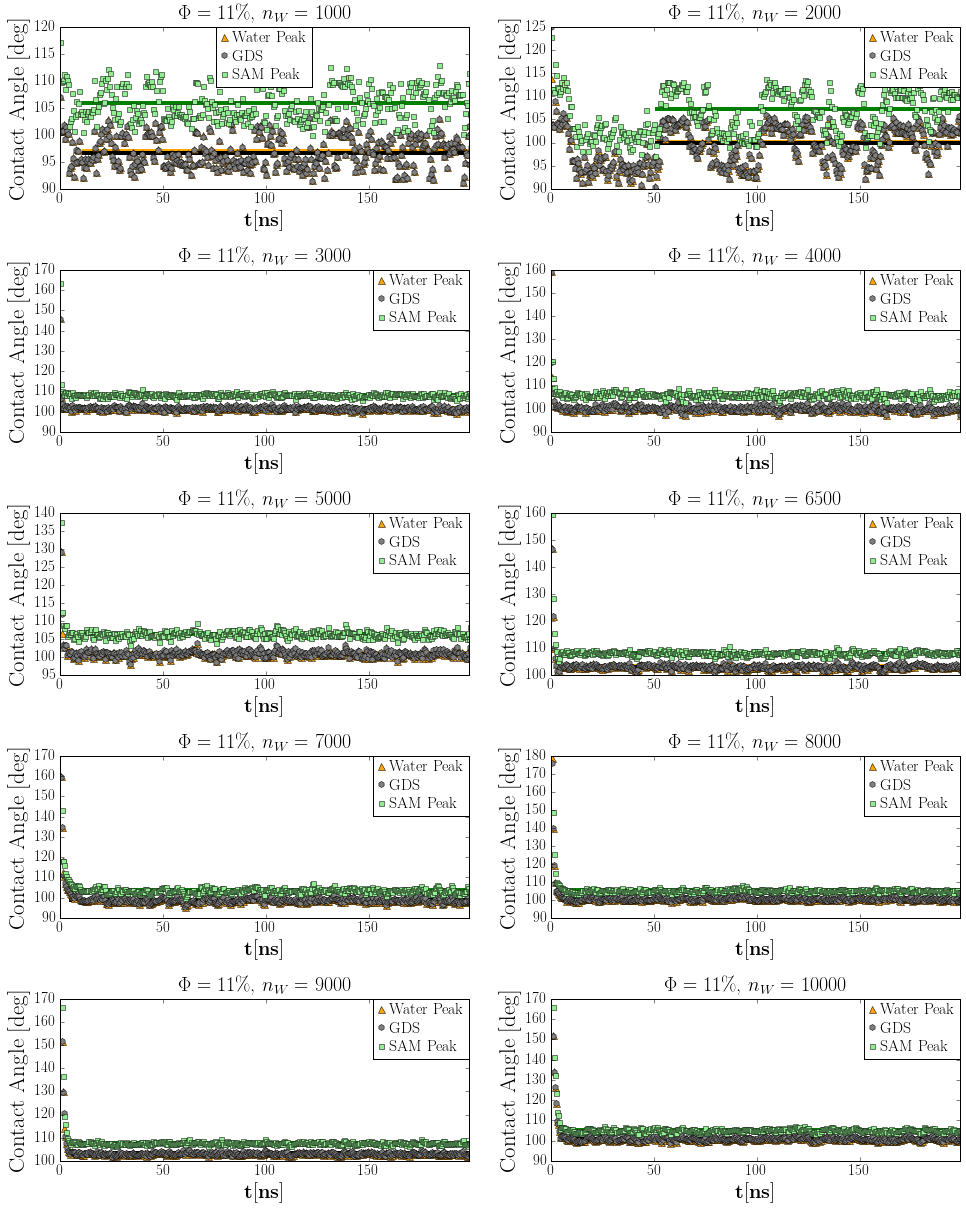

for SAM  11 % and  1000  molecules:
num of good intervals= 14
for SAM  11 % and  2000  molecules:
num of good intervals= 42
for SAM  11 % and  3000  molecules:
num of good intervals= 40
for SAM  11 % and  4000  molecules:
num of good intervals= 72
for SAM  11 % and  5000  molecules:
num of good intervals= 148
for SAM  11 % and  6500  molecules:
num of good intervals= 113
for SAM  11 % and  7000  molecules:
num of good intervals= 110
for SAM  11 % and  8000  molecules:
num of good intervals= 127
for SAM  11 % and  9000  molecules:
num of good intervals= 64
for SAM  11 % and  10000  molecules:
num of good intervals= 192


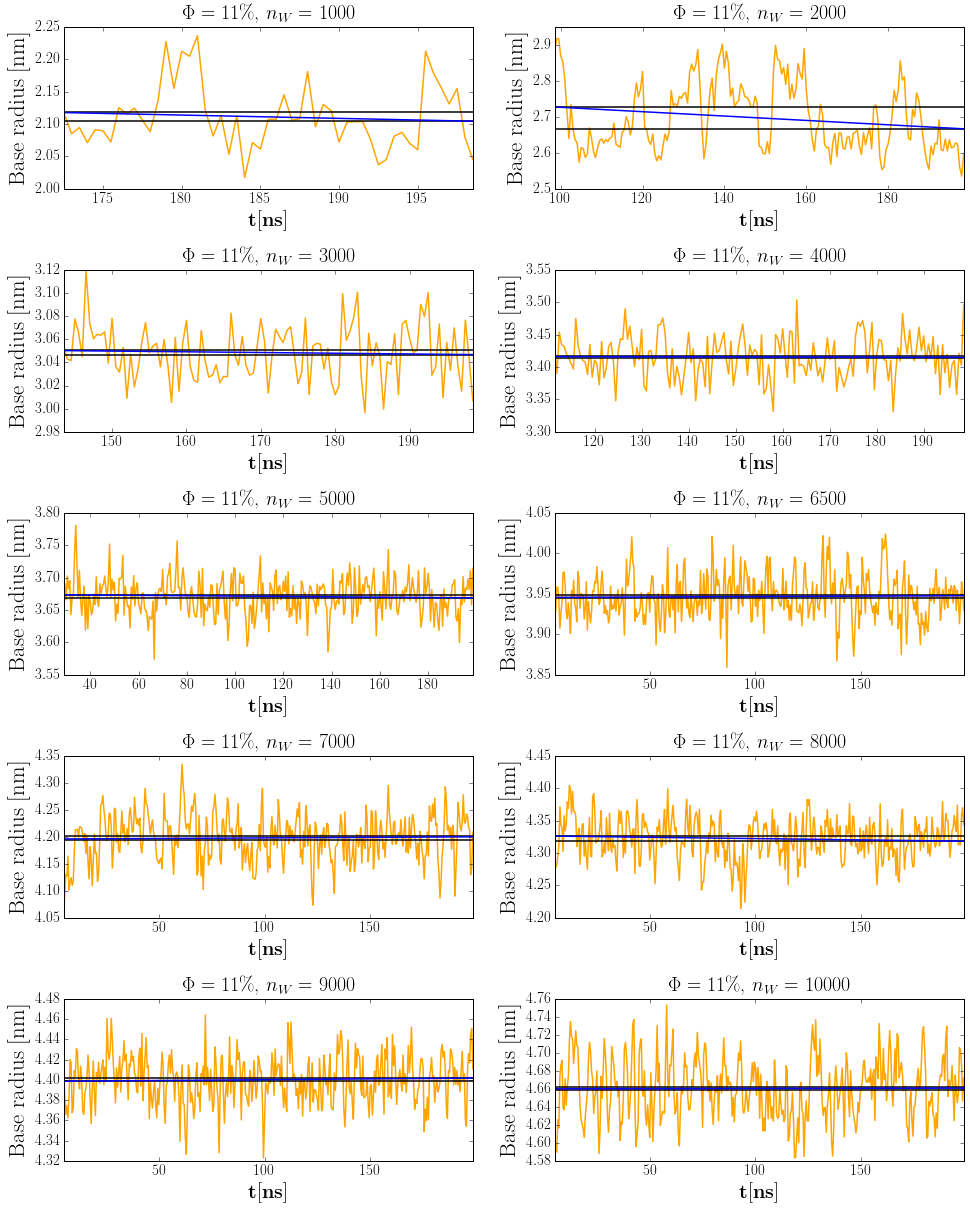

for SAM  11 % and  1000  molecules:
num of good intervals= 14
for SAM  11 % and  2000  molecules:
num of good intervals= 42
for SAM  11 % and  3000  molecules:
num of good intervals= 40
for SAM  11 % and  4000  molecules:
num of good intervals= 72
for SAM  11 % and  5000  molecules:
num of good intervals= 148
for SAM  11 % and  6500  molecules:
num of good intervals= 113
for SAM  11 % and  7000  molecules:
num of good intervals= 110
for SAM  11 % and  8000  molecules:
num of good intervals= 127
for SAM  11 % and  9000  molecules:
num of good intervals= 64
for SAM  11 % and  10000  molecules:
num of good intervals= 192


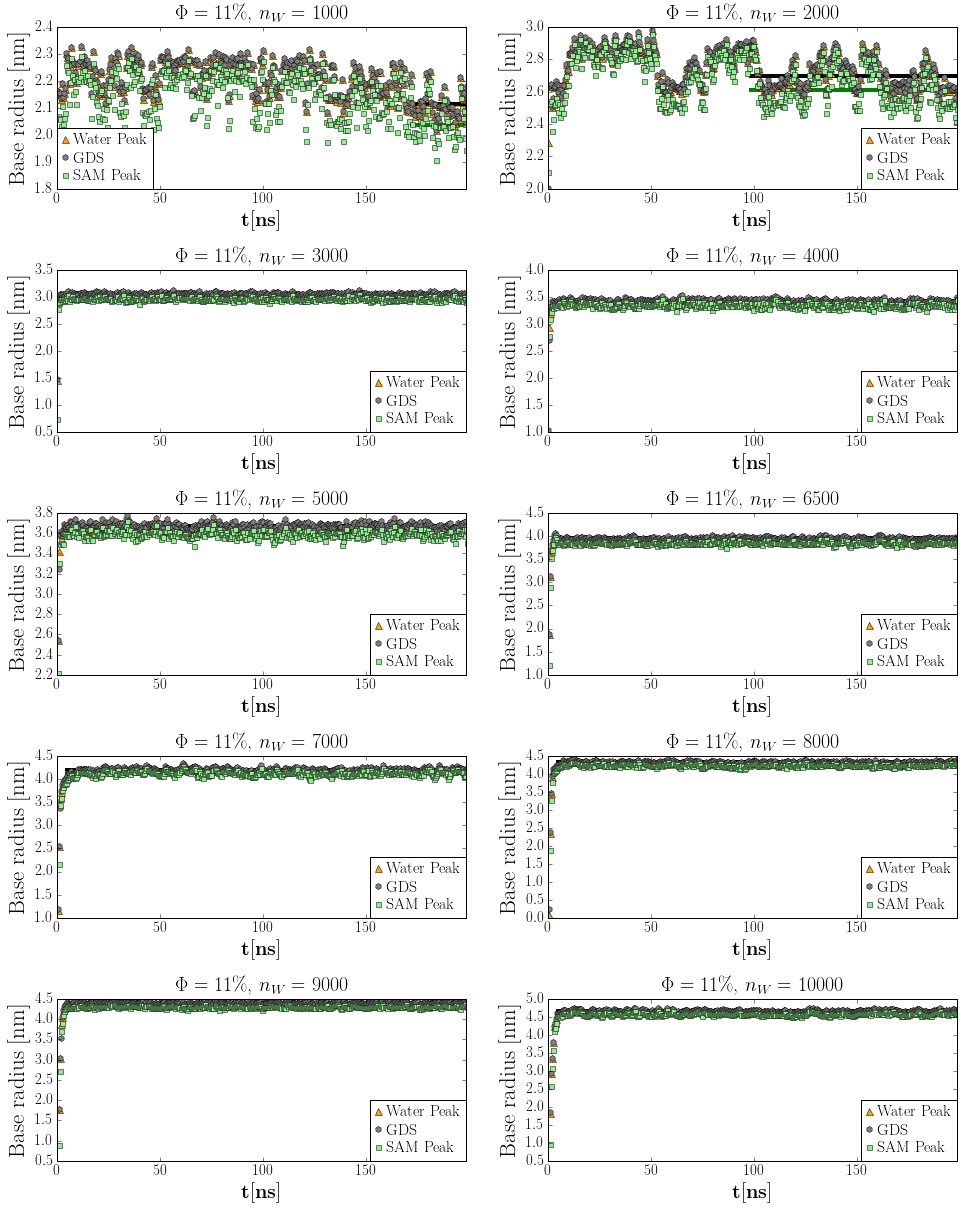

In [19]:
# Set parameters for plots of SAM with pc = 0%
pc=11

minblocksize=20 # The minimum block size is 10ns=20 points
beg = 10 # We leave out the first 5ns=10 points
blocksNum=3 #the function best_start uses also 3 blocks for averaging

Nrows = 5
Ncolumns = 2

loopvalues = Waters[11]

# Plot and analize Base Radii of equilibrated interval for GDS and SAM peak

theta_w[pc]=[] # microscopic contact angle of equilibrated system
errortheta_w[pc]=[] # error in the microscopic contact angle of equilibrated system
equil_theta_w[pc]=[] #equilibrated systems
#start_theta_w[pc]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_theta_w[pc]=[] # last t (time) of the simulation -> uncomment if needed

theta_w[pc],errortheta_w[pc],equil_theta_w[pc] = equil_results(loopvalues, angles_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, anglelabel, anglename)

# Plot and analize Contact Angles of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at MiddlePoint/GDS
errortheta_m[pc]=[]
theta_m[pc]=[]
equil_theta_m[pc]=[]
#start_theta_m[pc]=[] -> uncomment if needed
#end_theta_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
errortheta_s[pc]=[]
theta_s[pc]=[]
equil_theta_s[pc]=[]
#start_theta_s[pc]=[] -> uncomment if needed
#end_theta_s[pc]=[] -> uncomment if needed
    
theta_m[pc],errortheta_m[pc],equil_theta_m[pc],theta_s[pc],errortheta_s[pc],equil_theta_s[pc] =  whole_results(loopvalues, angles_w, angles_m, angles_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize,anglelabel, anglename)

# Plot and analize Base Radii of equilibrated interval for first water peak

error_rbase_w[pc]=[] # error in the microscopic contact angle of equilibrated system
rbase_w[pc]=[] # microscopic contact angle of equilibrated system
equil_rbase_w[pc]=[] #equilibrated systems
#start_rbase_w[b]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_rbase_w[b]=[] # last t (time) of the simulation -> uncomment if needed
    
rbase_w[pc],error_rbase_w[pc],equil_rbase_w[pc] = equil_results(loopvalues, radii_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

# Plot and analize Base Radii of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at GDS
error_rbase_m[pc]=[]
rbase_m[pc]=[]
equil_rbase_m[pc]=[]
#start_rbase_m[pc]=[] -> uncomment if needed
#end_rbase_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
error_rbase_s[pc]=[]
rbase_s[pc]=[]
equil_rbase_s[pc]=[]
#start_rbase_s[pc]=[] -> uncomment if needed
#end_rbase_s[pc]=[] -> uncomment if needed
    
rbase_m[pc],error_rbase_m[pc],equil_rbase_m[pc],rbase_s[pc],error_rbase_s[pc],equil_rbase_s[pc] =  whole_results(loopvalues, radii_w, radii_m, radii_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

for SAM  22 % and  1000  molecules:
num of good intervals= 153
for SAM  22 % and  2000  molecules:
num of good intervals= 139
for SAM  22 % and  3000  molecules:
num of good intervals= 53
for SAM  22 % and  4000  molecules:
num of good intervals= 16
for SAM  22 % and  5000  molecules:
num of good intervals= 159
for SAM  22 % and  6500  molecules:
num of good intervals= 140
for SAM  22 % and  7000  molecules:
num of good intervals= 121
for SAM  22 % and  8000  molecules:
num of good intervals= 61
for SAM  22 % and  9000  molecules:
num of good intervals= 33
for SAM  22 % and  10000  molecules:
num of good intervals= 125


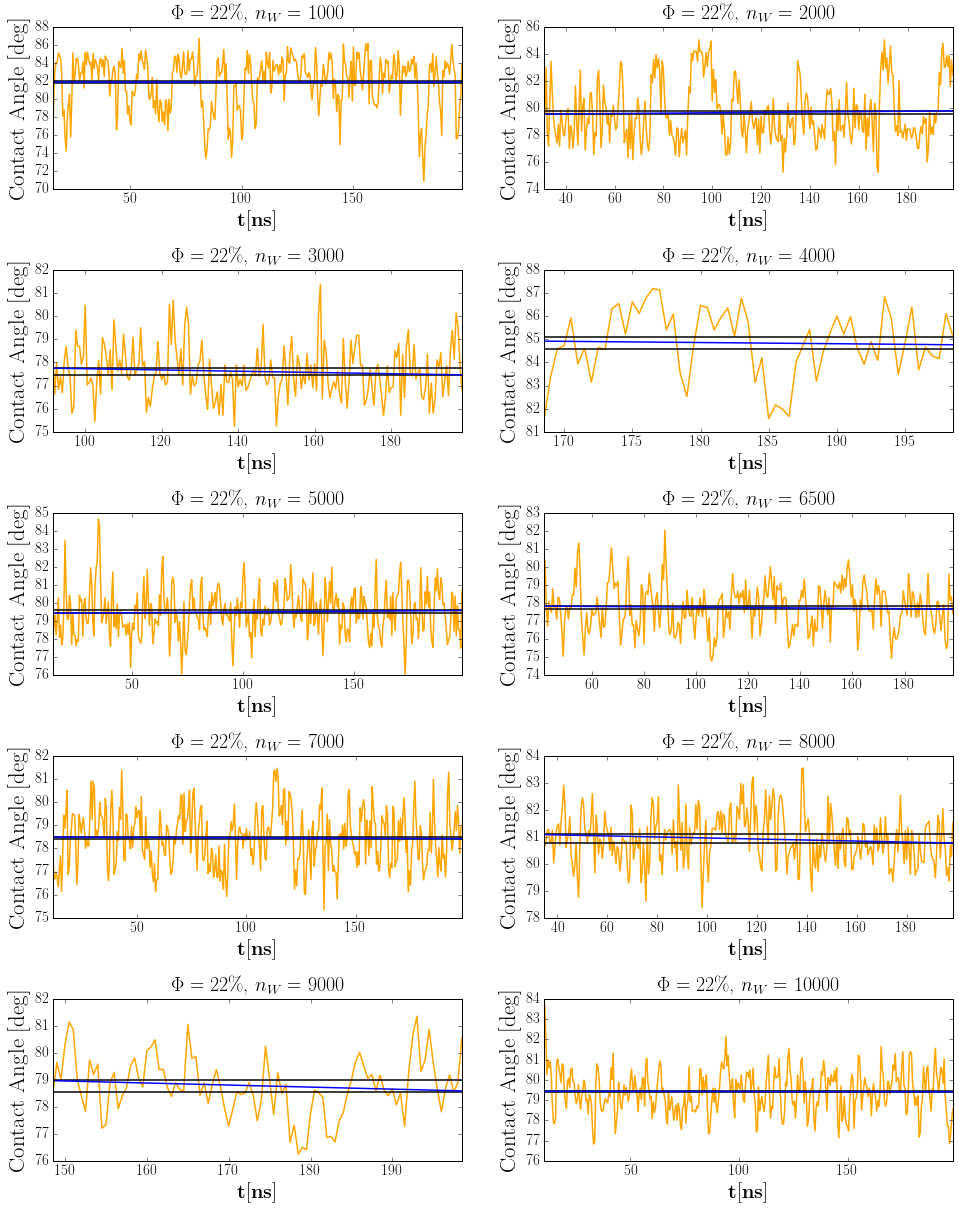

for SAM  22 % and  1000  molecules:
num of good intervals= 153
for SAM  22 % and  2000  molecules:
num of good intervals= 139
for SAM  22 % and  3000  molecules:
num of good intervals= 53
for SAM  22 % and  4000  molecules:
num of good intervals= 16
for SAM  22 % and  5000  molecules:
num of good intervals= 159
for SAM  22 % and  6500  molecules:
num of good intervals= 140
for SAM  22 % and  7000  molecules:
num of good intervals= 121
for SAM  22 % and  8000  molecules:
num of good intervals= 61
for SAM  22 % and  9000  molecules:
num of good intervals= 33
for SAM  22 % and  10000  molecules:
num of good intervals= 125


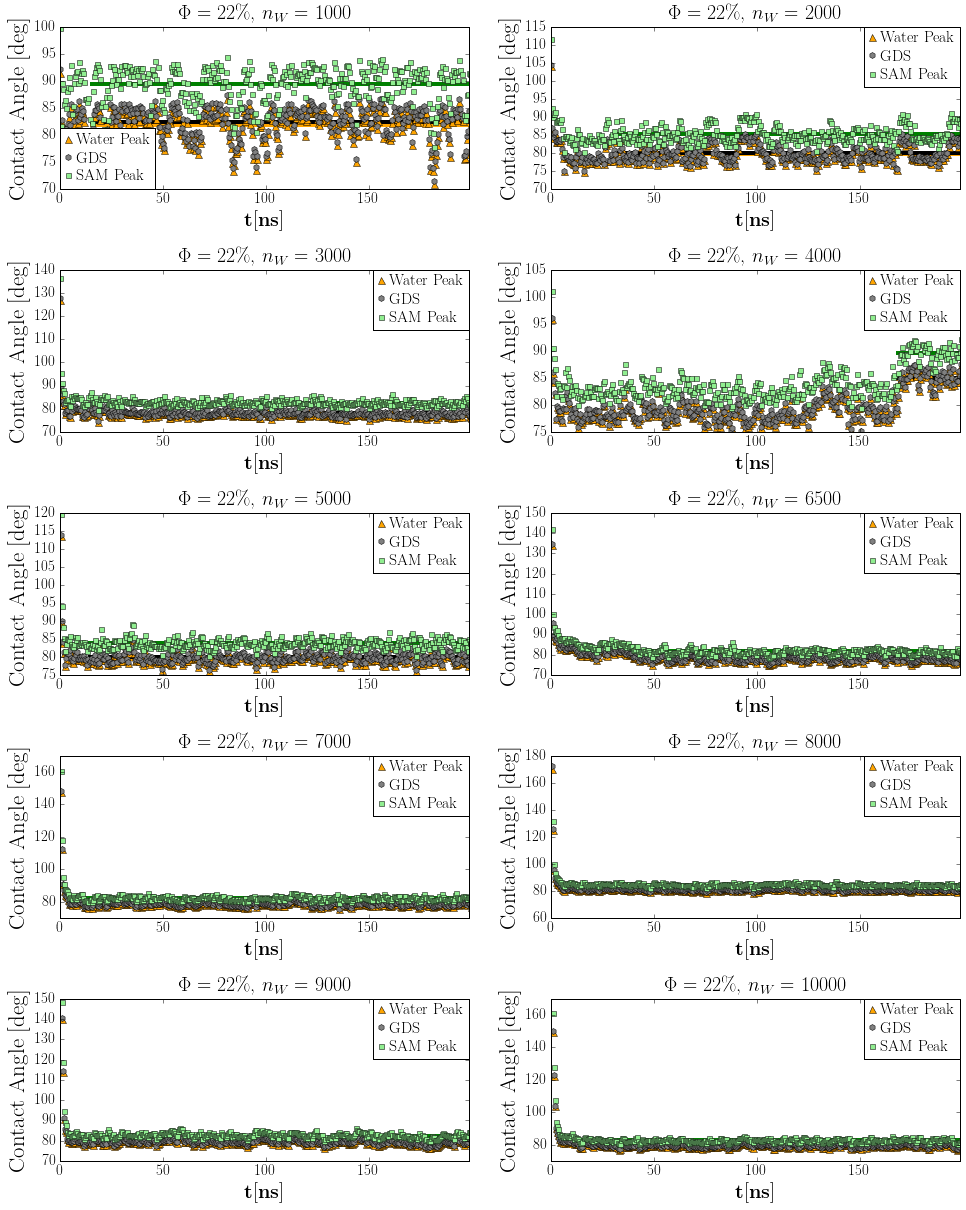

for SAM  22 % and  1000  molecules:
num of good intervals= 97
for SAM  22 % and  2000  molecules:
num of good intervals= 38
for SAM  22 % and  3000  molecules:
num of good intervals= 32
for SAM  22 % and  4000  molecules:
num of good intervals= 20
for SAM  22 % and  5000  molecules:
num of good intervals= 59
for SAM  22 % and  6500  molecules:
num of good intervals= 135
for SAM  22 % and  7000  molecules:
num of good intervals= 114
for SAM  22 % and  8000  molecules:
num of good intervals= 56
for SAM  22 % and  9000  molecules:
num of good intervals= 36
for SAM  22 % and  10000  molecules:
num of good intervals= 132


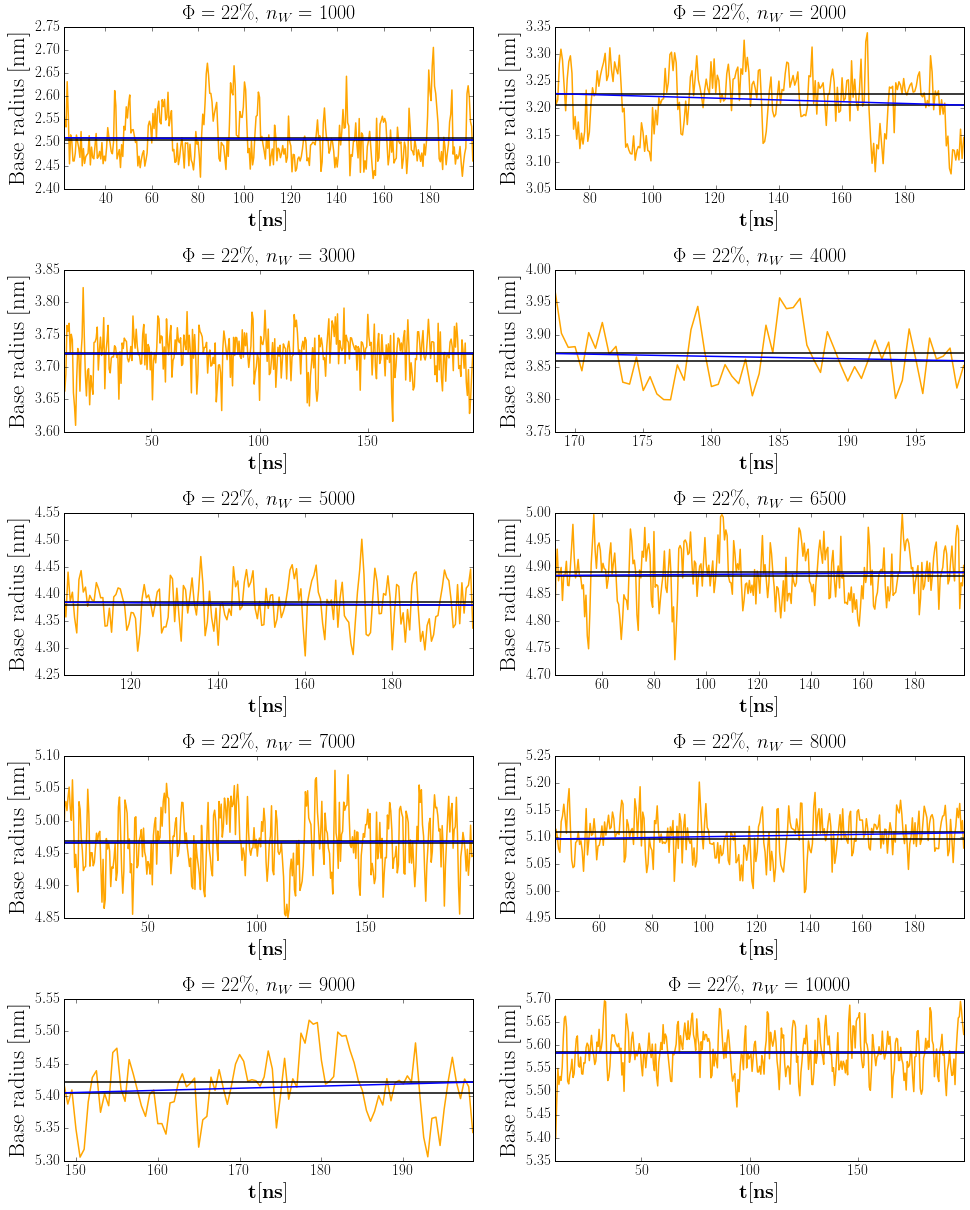

for SAM  22 % and  1000  molecules:
num of good intervals= 97
for SAM  22 % and  2000  molecules:
num of good intervals= 38
for SAM  22 % and  3000  molecules:
num of good intervals= 32
for SAM  22 % and  4000  molecules:
num of good intervals= 20
for SAM  22 % and  5000  molecules:
num of good intervals= 59
for SAM  22 % and  6500  molecules:
num of good intervals= 135
for SAM  22 % and  7000  molecules:
num of good intervals= 114
for SAM  22 % and  8000  molecules:
num of good intervals= 56
for SAM  22 % and  9000  molecules:
num of good intervals= 36
for SAM  22 % and  10000  molecules:
num of good intervals= 132


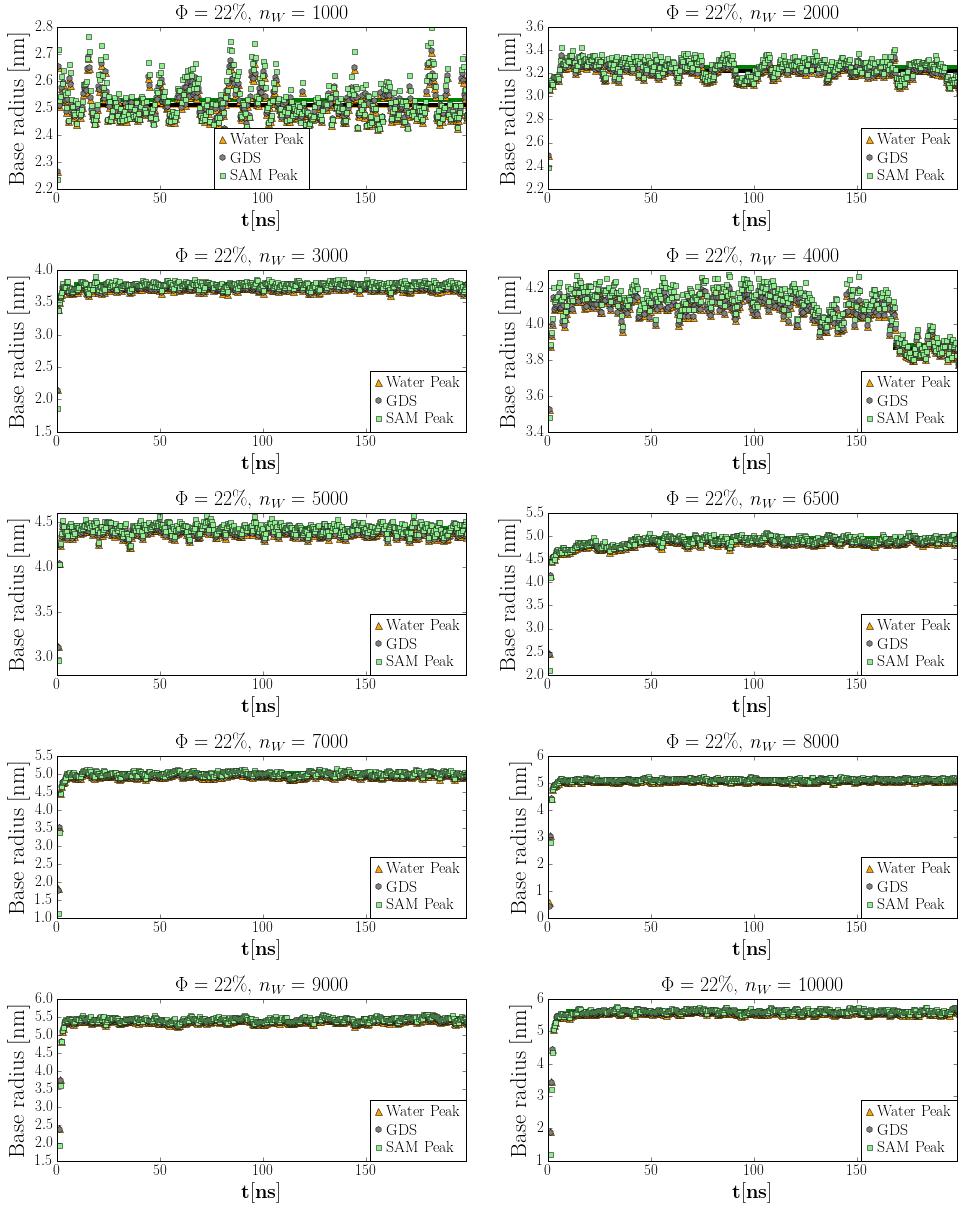

In [20]:
# Set parameters for plots of SAM with pc = 0%
pc=22

minblocksize=20 # The minimum block size is 10ns=20 points
beg = 10 # We leave out the first 5ns=10 points
blocksNum=3 #the function best_start uses also 3 blocks for averaging

Nrows = 5
Ncolumns = 2

loopvalues = Waters[22]

# Plot and analize Base Radii of equilibrated interval for GDS and SAM peak

theta_w[pc]=[] # microscopic contact angle of equilibrated system
errortheta_w[pc]=[] # error in the microscopic contact angle of equilibrated system
equil_theta_w[pc]=[] #equilibrated systems
#start_theta_w[pc]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_theta_w[pc]=[] # last t (time) of the simulation -> uncomment if needed

theta_w[pc],errortheta_w[pc],equil_theta_w[pc] = equil_results(loopvalues, angles_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, anglelabel, anglename)

# Plot and analize Contact Angles of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at MiddlePoint/GDS
errortheta_m[pc]=[]
theta_m[pc]=[]
equil_theta_m[pc]=[]
#start_theta_m[pc]=[] -> uncomment if needed
#end_theta_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
errortheta_s[pc]=[]
theta_s[pc]=[]
equil_theta_s[pc]=[]
#start_theta_s[pc]=[] -> uncomment if needed
#end_theta_s[pc]=[] -> uncomment if needed
    
theta_m[pc],errortheta_m[pc],equil_theta_m[pc],theta_s[pc],errortheta_s[pc],equil_theta_s[pc] =  whole_results(loopvalues, angles_w, angles_m, angles_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize,anglelabel, anglename)

# Plot and analize Base Radii of equilibrated interval for first water peak

error_rbase_w[pc]=[] # error in the microscopic contact angle of equilibrated system
rbase_w[pc]=[] # microscopic contact angle of equilibrated system
equil_rbase_w[pc]=[] #equilibrated systems
#start_rbase_w[b]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_rbase_w[b]=[] # last t (time) of the simulation -> uncomment if needed
    
rbase_w[pc],error_rbase_w[pc],equil_rbase_w[pc] = equil_results(loopvalues, radii_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

# Plot and analize Base Radii of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at GDS
error_rbase_m[pc]=[]
rbase_m[pc]=[]
equil_rbase_m[pc]=[]
#start_rbase_m[pc]=[] -> uncomment if needed
#end_rbase_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
error_rbase_s[pc]=[]
rbase_s[pc]=[]
equil_rbase_s[pc]=[]
#start_rbase_s[pc]=[] -> uncomment if needed
#end_rbase_s[pc]=[] -> uncomment if needed
    
rbase_m[pc],error_rbase_m[pc],equil_rbase_m[pc],rbase_s[pc],error_rbase_s[pc],equil_rbase_s[pc] =  whole_results(loopvalues, radii_w, radii_m, radii_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

for SAM  33 % and  1000  molecules:
num of good intervals= 94
for SAM  33 % and  2000  molecules:
num of good intervals= 173
for SAM  33 % and  3000  molecules:
num of good intervals= 195
for SAM  33 % and  4000  molecules:
num of good intervals= 102
for SAM  33 % and  5000  molecules:
num of good intervals= 74
for SAM  33 % and  6500  molecules:
num of good intervals= 80
for SAM  33 % and  7000  molecules:
num of good intervals= 42
for SAM  33 % and  8000  molecules:
num of good intervals= 29
for SAM  33 % and  9000  molecules:
num of good intervals= 200
for SAM  33 % and  10000  molecules:
num of good intervals= 71


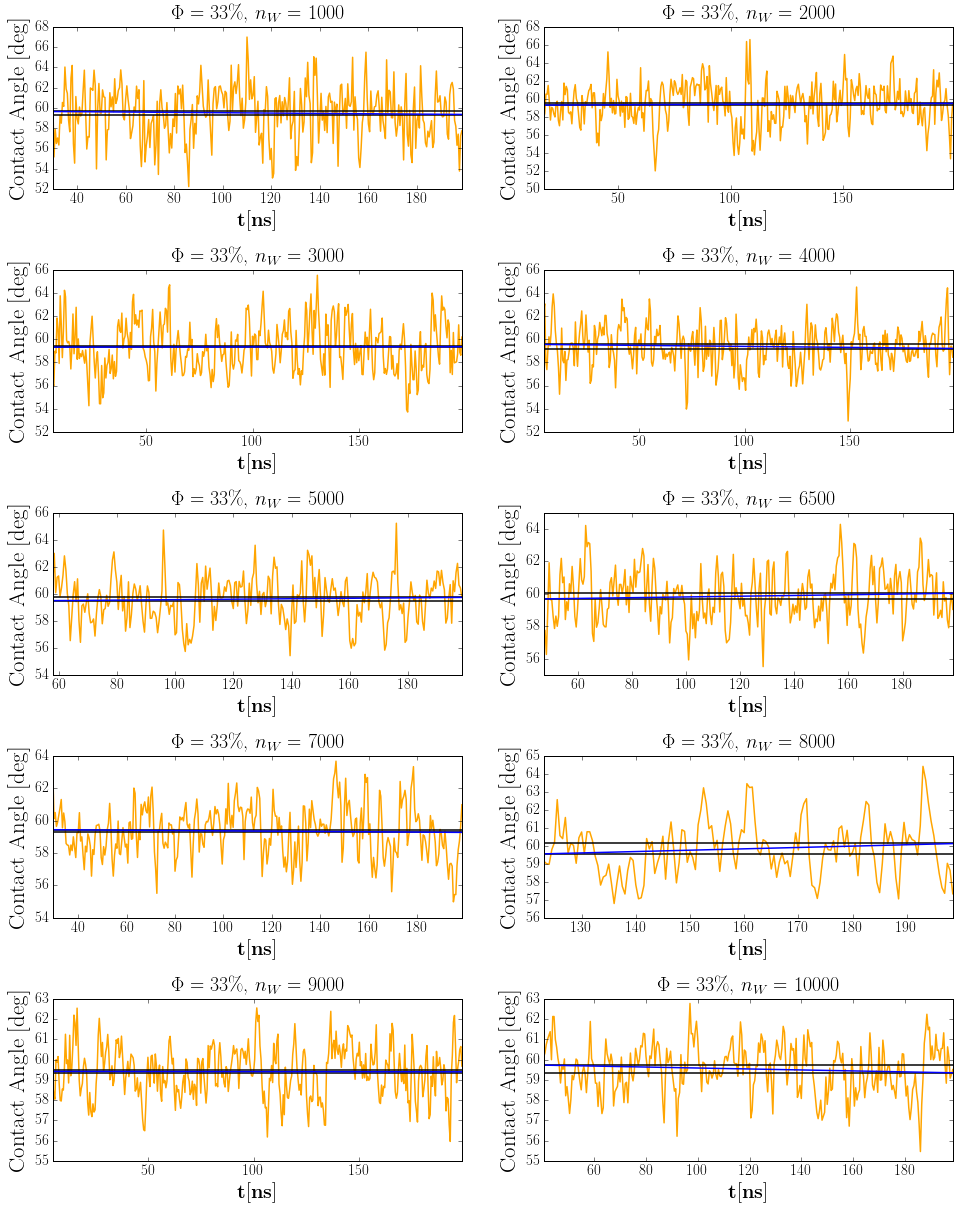

for SAM  33 % and  1000  molecules:
num of good intervals= 94
for SAM  33 % and  2000  molecules:
num of good intervals= 173
for SAM  33 % and  3000  molecules:
num of good intervals= 195
for SAM  33 % and  4000  molecules:
num of good intervals= 102
for SAM  33 % and  5000  molecules:
num of good intervals= 74
for SAM  33 % and  6500  molecules:
num of good intervals= 80
for SAM  33 % and  7000  molecules:
num of good intervals= 42
for SAM  33 % and  8000  molecules:
num of good intervals= 29
for SAM  33 % and  9000  molecules:
num of good intervals= 200
for SAM  33 % and  10000  molecules:
num of good intervals= 71


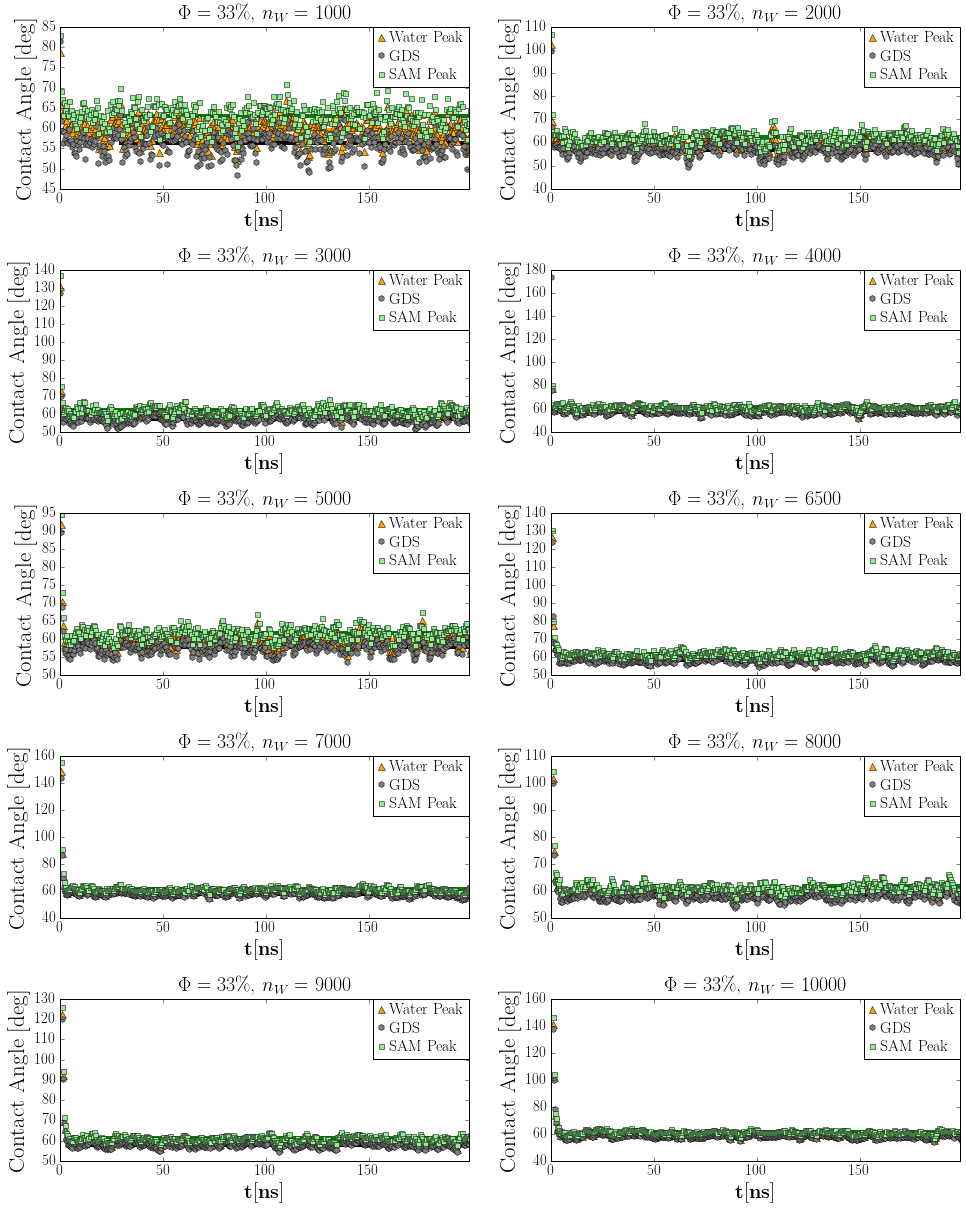

for SAM  33 % and  1000  molecules:
num of good intervals= 74
for SAM  33 % and  2000  molecules:
num of good intervals= 39
for SAM  33 % and  3000  molecules:
num of good intervals= 178
for SAM  33 % and  4000  molecules:
num of good intervals= 98
for SAM  33 % and  5000  molecules:
num of good intervals= 81
for SAM  33 % and  6500  molecules:
num of good intervals= 78
for SAM  33 % and  7000  molecules:
num of good intervals= 61
for SAM  33 % and  8000  molecules:
num of good intervals= 23
for SAM  33 % and  9000  molecules:
num of good intervals= 200
for SAM  33 % and  10000  molecules:
num of good intervals= 72


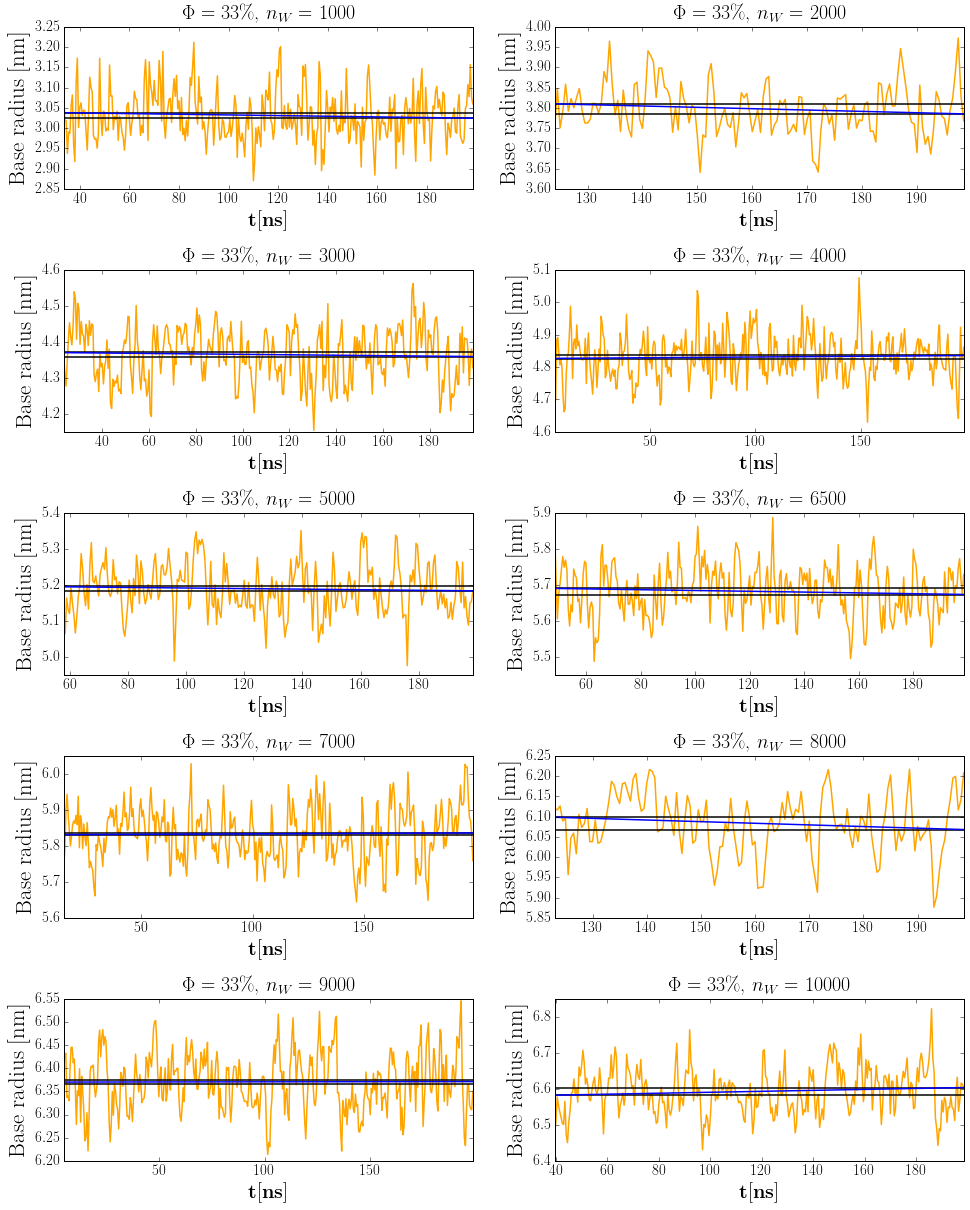

for SAM  33 % and  1000  molecules:
num of good intervals= 74
for SAM  33 % and  2000  molecules:
num of good intervals= 39
for SAM  33 % and  3000  molecules:
num of good intervals= 178
for SAM  33 % and  4000  molecules:
num of good intervals= 98
for SAM  33 % and  5000  molecules:
num of good intervals= 81
for SAM  33 % and  6500  molecules:
num of good intervals= 78
for SAM  33 % and  7000  molecules:
num of good intervals= 61
for SAM  33 % and  8000  molecules:
num of good intervals= 23
for SAM  33 % and  9000  molecules:
num of good intervals= 200
for SAM  33 % and  10000  molecules:
num of good intervals= 72


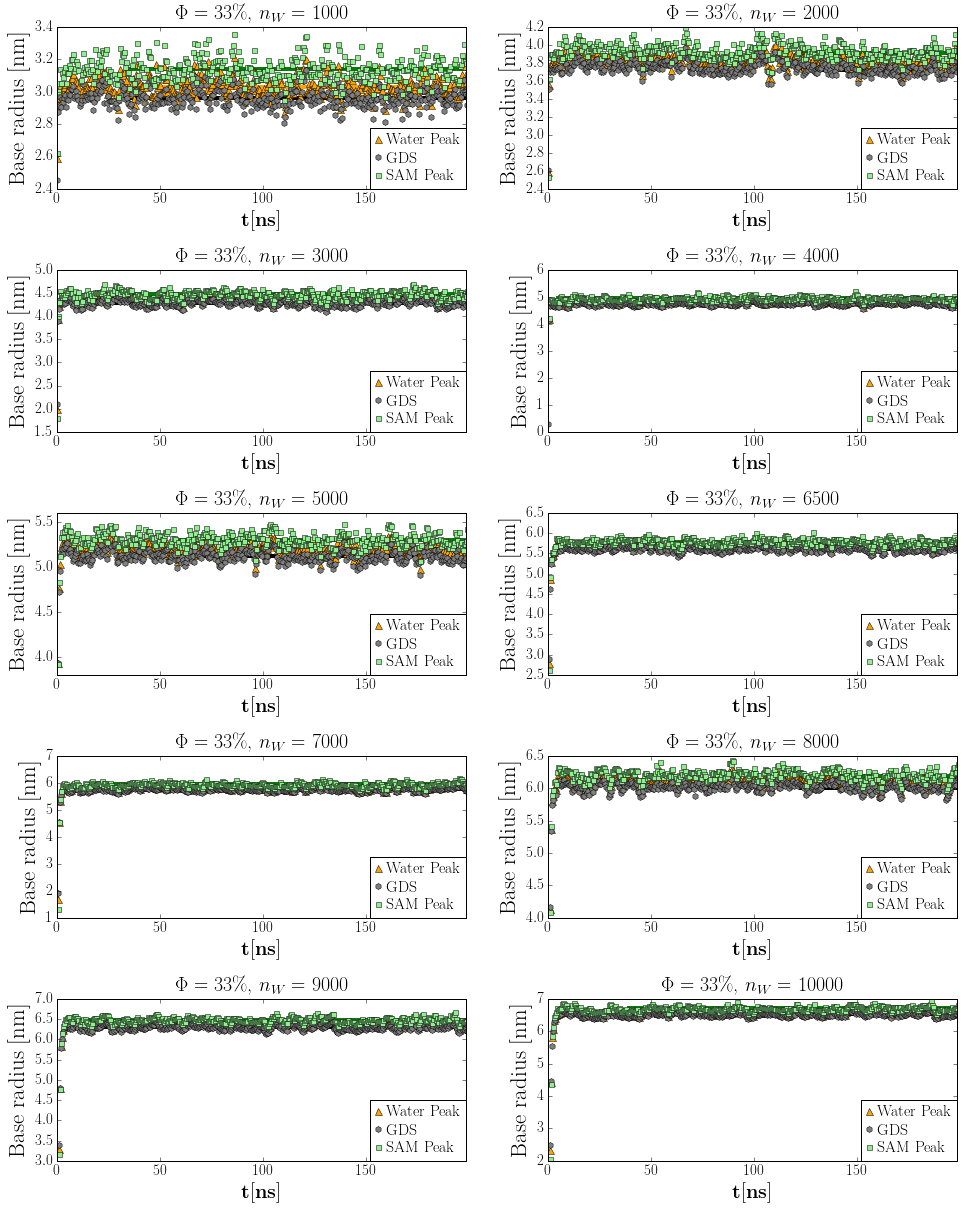

In [21]:
# Set parameters for plots of SAM with pc = 0%
pc=33

minblocksize=20 # The minimum block size is 10ns=20 points
beg = 10 # We leave out the first 5ns=10 points
blocksNum=3 #the function best_start uses also 3 blocks for averaging

Nrows = 5
Ncolumns = 2

loopvalues = Waters[33]

# Plot and analize Base Radii of equilibrated interval for GDS and SAM peak

theta_w[pc]=[] # microscopic contact angle of equilibrated system
errortheta_w[pc]=[] # error in the microscopic contact angle of equilibrated system
equil_theta_w[pc]=[] #equilibrated systems
#start_theta_w[pc]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_theta_w[pc]=[] # last t (time) of the simulation -> uncomment if needed

theta_w[pc],errortheta_w[pc],equil_theta_w[pc] = equil_results(loopvalues, angles_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, anglelabel, anglename)

# Plot and analize Contact Angles of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at MiddlePoint/GDS
errortheta_m[pc]=[]
theta_m[pc]=[]
equil_theta_m[pc]=[]
#start_theta_m[pc]=[] -> uncomment if needed
#end_theta_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
errortheta_s[pc]=[]
theta_s[pc]=[]
equil_theta_s[pc]=[]
#start_theta_s[pc]=[] -> uncomment if needed
#end_theta_s[pc]=[] -> uncomment if needed
    
theta_m[pc],errortheta_m[pc],equil_theta_m[pc],theta_s[pc],errortheta_s[pc],equil_theta_s[pc] =  whole_results(loopvalues, angles_w, angles_m, angles_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize,anglelabel, anglename)

# Plot and analize Base Radii of equilibrated interval for first water peak

error_rbase_w[pc]=[] # error in the microscopic contact angle of equilibrated system
rbase_w[pc]=[] # microscopic contact angle of equilibrated system
equil_rbase_w[pc]=[] #equilibrated systems
#start_rbase_w[b]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_rbase_w[b]=[] # last t (time) of the simulation -> uncomment if needed
    
rbase_w[pc],error_rbase_w[pc],equil_rbase_w[pc] = equil_results(loopvalues, radii_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

# Plot and analize Base Radii of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at GDS
error_rbase_m[pc]=[]
rbase_m[pc]=[]
equil_rbase_m[pc]=[]
#start_rbase_m[pc]=[] -> uncomment if needed
#end_rbase_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
error_rbase_s[pc]=[]
rbase_s[pc]=[]
equil_rbase_s[pc]=[]
#start_rbase_s[pc]=[] -> uncomment if needed
#end_rbase_s[pc]=[] -> uncomment if needed
    
rbase_m[pc],error_rbase_m[pc],equil_rbase_m[pc],rbase_s[pc],error_rbase_s[pc],equil_rbase_s[pc] =  whole_results(loopvalues, radii_w, radii_m, radii_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

for SAM  37 % and  1000  molecules:
num of good intervals= 80
for SAM  37 % and  2000  molecules:
num of good intervals= 101
for SAM  37 % and  4000  molecules:
num of good intervals= 33
for SAM  37 % and  5000  molecules:
num of good intervals= 97
for SAM  37 % and  6500  molecules:
num of good intervals= 80
for SAM  37 % and  7000  molecules:
num of good intervals= 97
for SAM  37 % and  8000  molecules:
num of good intervals= 59
for SAM  37 % and  9000  molecules:
num of good intervals= 83


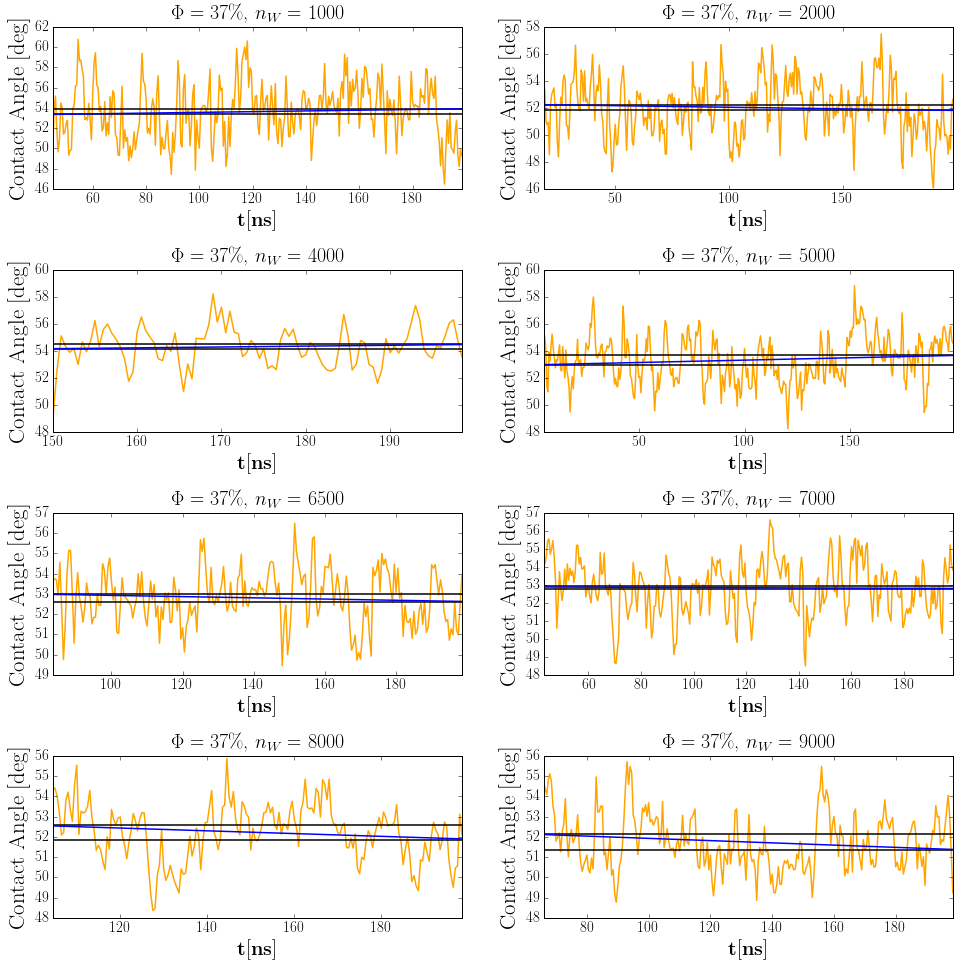

for SAM  37 % and  1000  molecules:
num of good intervals= 80
for SAM  37 % and  2000  molecules:
num of good intervals= 101
for SAM  37 % and  4000  molecules:
num of good intervals= 33
for SAM  37 % and  5000  molecules:
num of good intervals= 97
for SAM  37 % and  6500  molecules:
num of good intervals= 80
for SAM  37 % and  7000  molecules:
num of good intervals= 97
for SAM  37 % and  8000  molecules:
num of good intervals= 59
for SAM  37 % and  9000  molecules:
num of good intervals= 83


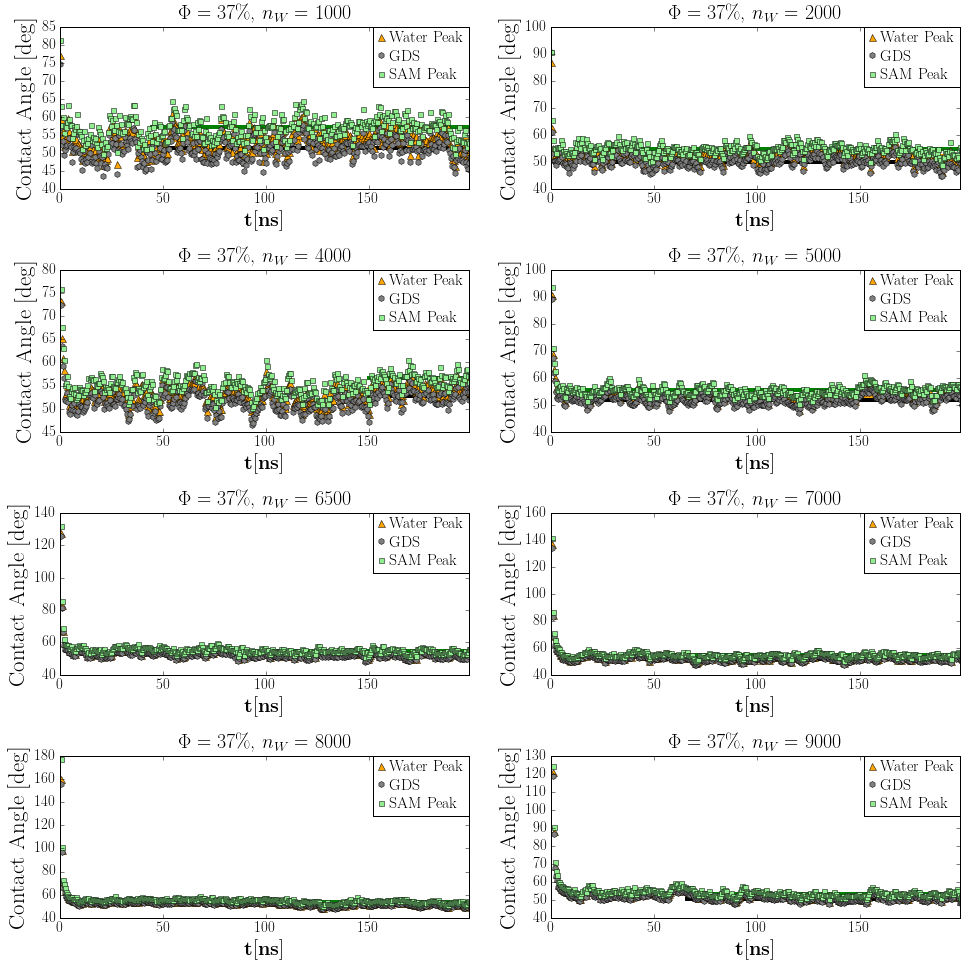

for SAM  37 % and  1000  molecules:
num of good intervals= 56
for SAM  37 % and  2000  molecules:
num of good intervals= 77
for SAM  37 % and  4000  molecules:
num of good intervals= 11
for SAM  37 % and  5000  molecules:
num of good intervals= 19
for SAM  37 % and  6500  molecules:
num of good intervals= 99
for SAM  37 % and  7000  molecules:
num of good intervals= 104
for SAM  37 % and  8000  molecules:
num of good intervals= 61
for SAM  37 % and  9000  molecules:
num of good intervals= 87


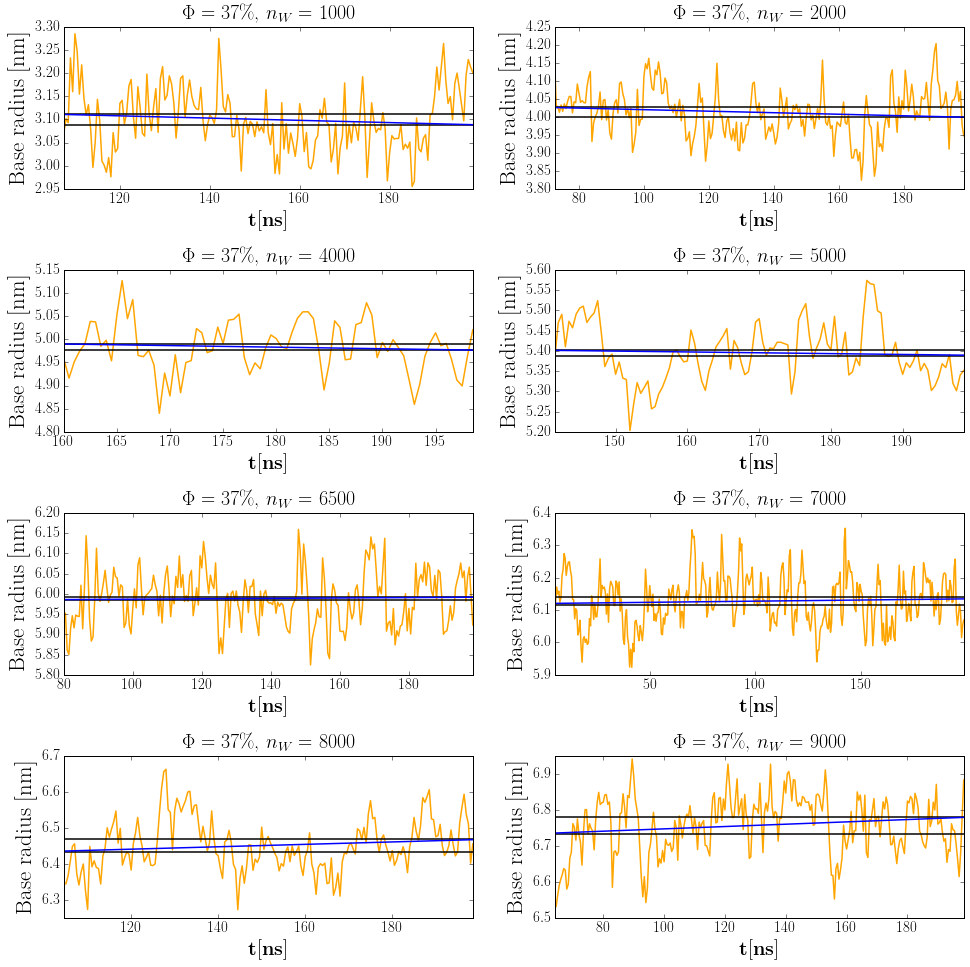

for SAM  37 % and  1000  molecules:
num of good intervals= 56
for SAM  37 % and  2000  molecules:
num of good intervals= 77
for SAM  37 % and  4000  molecules:
num of good intervals= 11
for SAM  37 % and  5000  molecules:
num of good intervals= 19
for SAM  37 % and  6500  molecules:
num of good intervals= 99
for SAM  37 % and  7000  molecules:
num of good intervals= 104
for SAM  37 % and  8000  molecules:
num of good intervals= 61
for SAM  37 % and  9000  molecules:
num of good intervals= 87


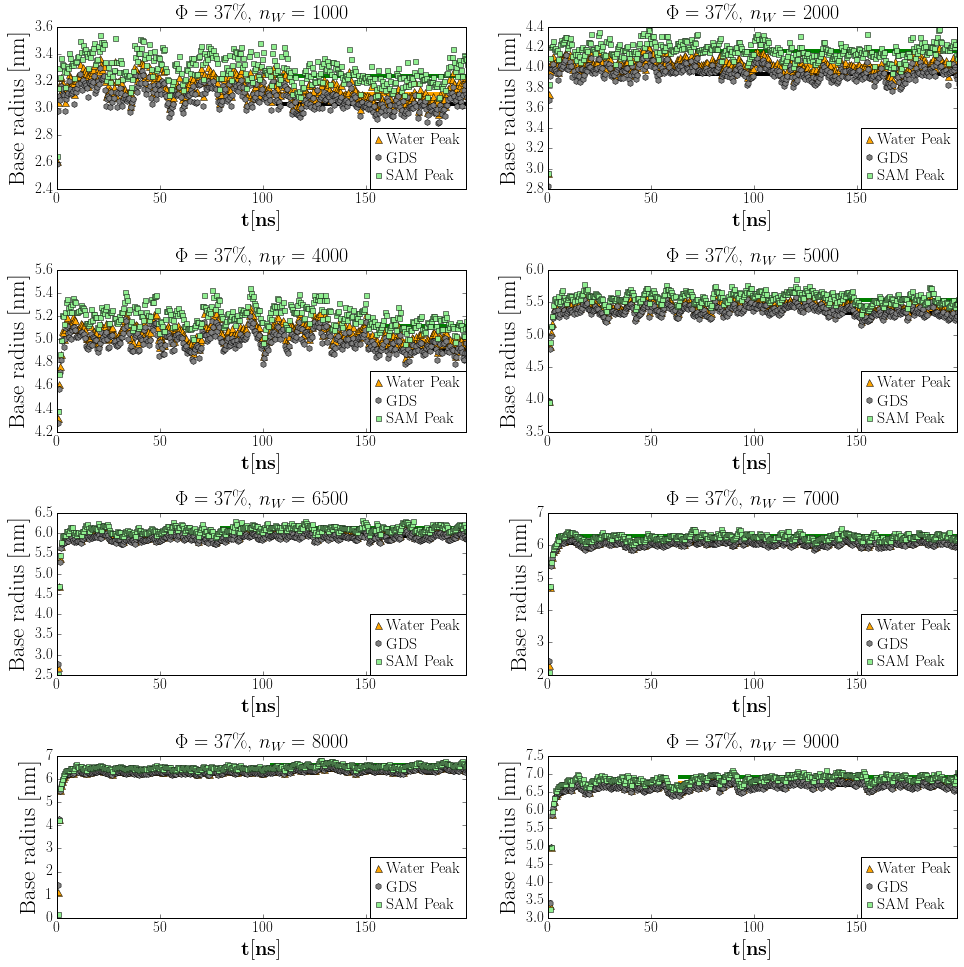

In [22]:
# Set parameters for plots of SAM with pc = 0%
pc=37

minblocksize=20 # The minimum block size is 10ns=20 points
beg = 10 # We leave out the first 5ns=10 points
blocksNum=3 #the function best_start uses also 3 blocks for averaging

Nrows = 5
Ncolumns = 2

loopvalues = Waters[37]

# Plot and analize Base Radii of equilibrated interval for GDS and SAM peak

theta_w[pc]=[] # microscopic contact angle of equilibrated system
errortheta_w[pc]=[] # error in the microscopic contact angle of equilibrated system
equil_theta_w[pc]=[] #equilibrated systems
#start_theta_w[pc]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_theta_w[pc]=[] # last t (time) of the simulation -> uncomment if needed

theta_w[pc],errortheta_w[pc],equil_theta_w[pc] = equil_results(loopvalues, angles_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, anglelabel, anglename)

# Plot and analize Contact Angles of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at MiddlePoint/GDS
errortheta_m[pc]=[]
theta_m[pc]=[]
equil_theta_m[pc]=[]
#start_theta_m[pc]=[] -> uncomment if needed
#end_theta_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
errortheta_s[pc]=[]
theta_s[pc]=[]
equil_theta_s[pc]=[]
#start_theta_s[pc]=[] -> uncomment if needed
#end_theta_s[pc]=[] -> uncomment if needed
    
theta_m[pc],errortheta_m[pc],equil_theta_m[pc],theta_s[pc],errortheta_s[pc],equil_theta_s[pc] =  whole_results(loopvalues, angles_w, angles_m, angles_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize,anglelabel, anglename)

# Plot and analize Base Radii of equilibrated interval for first water peak

error_rbase_w[pc]=[] # error in the microscopic contact angle of equilibrated system
rbase_w[pc]=[] # microscopic contact angle of equilibrated system
equil_rbase_w[pc]=[] #equilibrated systems
#start_rbase_w[b]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_rbase_w[b]=[] # last t (time) of the simulation -> uncomment if needed
    
rbase_w[pc],error_rbase_w[pc],equil_rbase_w[pc] = equil_results(loopvalues, radii_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

# Plot and analize Base Radii of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at GDS
error_rbase_m[pc]=[]
rbase_m[pc]=[]
equil_rbase_m[pc]=[]
#start_rbase_m[pc]=[] -> uncomment if needed
#end_rbase_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
error_rbase_s[pc]=[]
rbase_s[pc]=[]
equil_rbase_s[pc]=[]
#start_rbase_s[pc]=[] -> uncomment if needed
#end_rbase_s[pc]=[] -> uncomment if needed
    
rbase_m[pc],error_rbase_m[pc],equil_rbase_m[pc],rbase_s[pc],error_rbase_s[pc],equil_rbase_s[pc] =  whole_results(loopvalues, radii_w, radii_m, radii_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

for SAM  44 % and  1000  molecules:
num of good intervals= 30
for SAM  44 % and  2000  molecules:
num of good intervals= 38
for SAM  44 % and  3000  molecules:
num of good intervals= 191
for SAM  44 % and  4000  molecules:
num of good intervals= 103
for SAM  44 % and  5000  molecules:
num of good intervals= 88
for SAM  44 % and  6500  molecules:
num of good intervals= 123
for SAM  44 % and  7000  molecules:
 Not equilibrated!
for SAM  44 % and  8000  molecules:
 Not equilibrated!
for SAM  44 % and  9000  molecules:
num of good intervals= 6


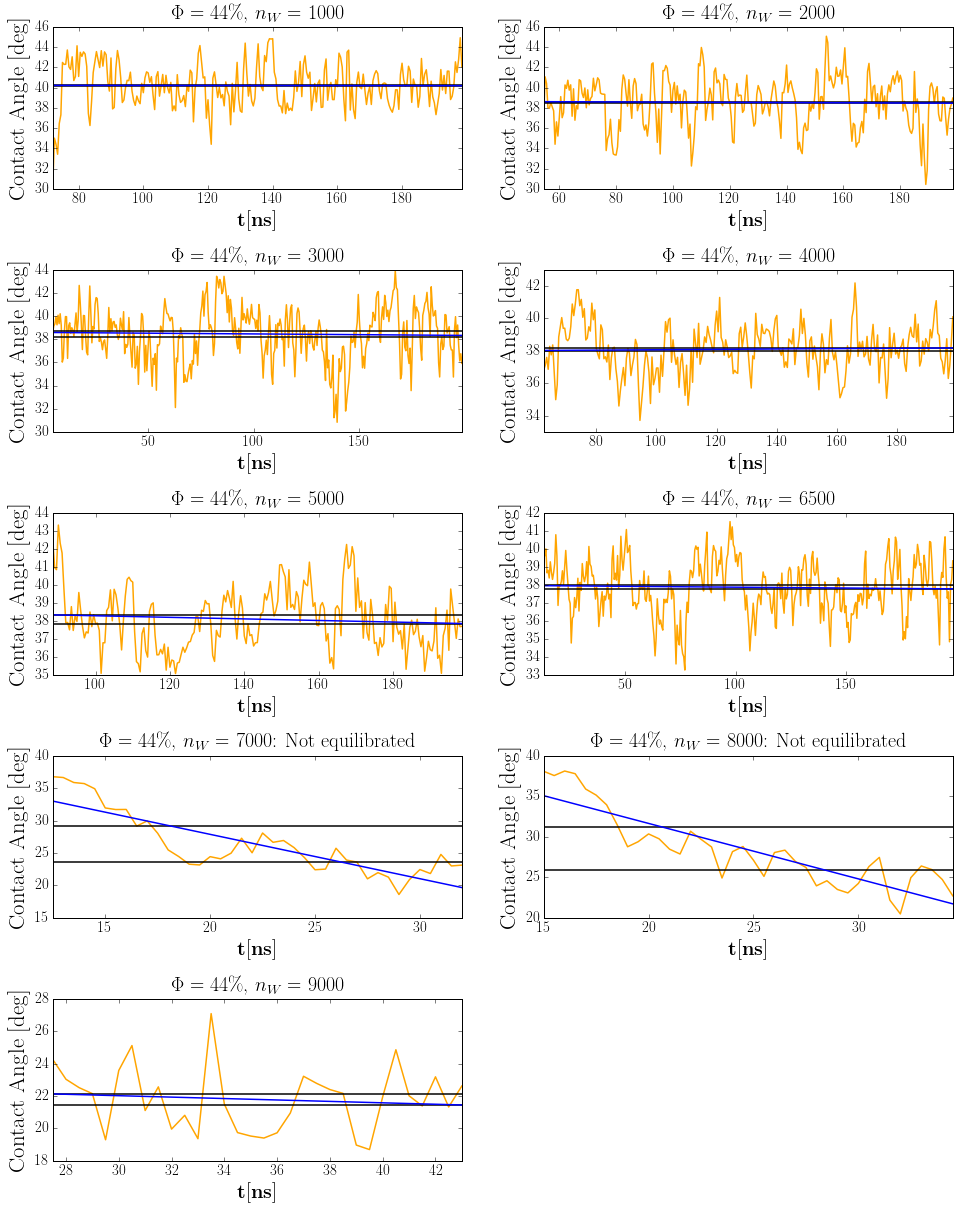

for SAM  44 % and  1000  molecules:
num of good intervals= 30
for SAM  44 % and  2000  molecules:
num of good intervals= 38
for SAM  44 % and  3000  molecules:
num of good intervals= 191
for SAM  44 % and  4000  molecules:
num of good intervals= 103
for SAM  44 % and  5000  molecules:
num of good intervals= 88
for SAM  44 % and  6500  molecules:
num of good intervals= 123
for SAM  44 % and  7000  molecules:
 Not equilibrated!
for SAM  44 % and  8000  molecules:
 Not equilibrated!
for SAM  44 % and  9000  molecules:
num of good intervals= 6


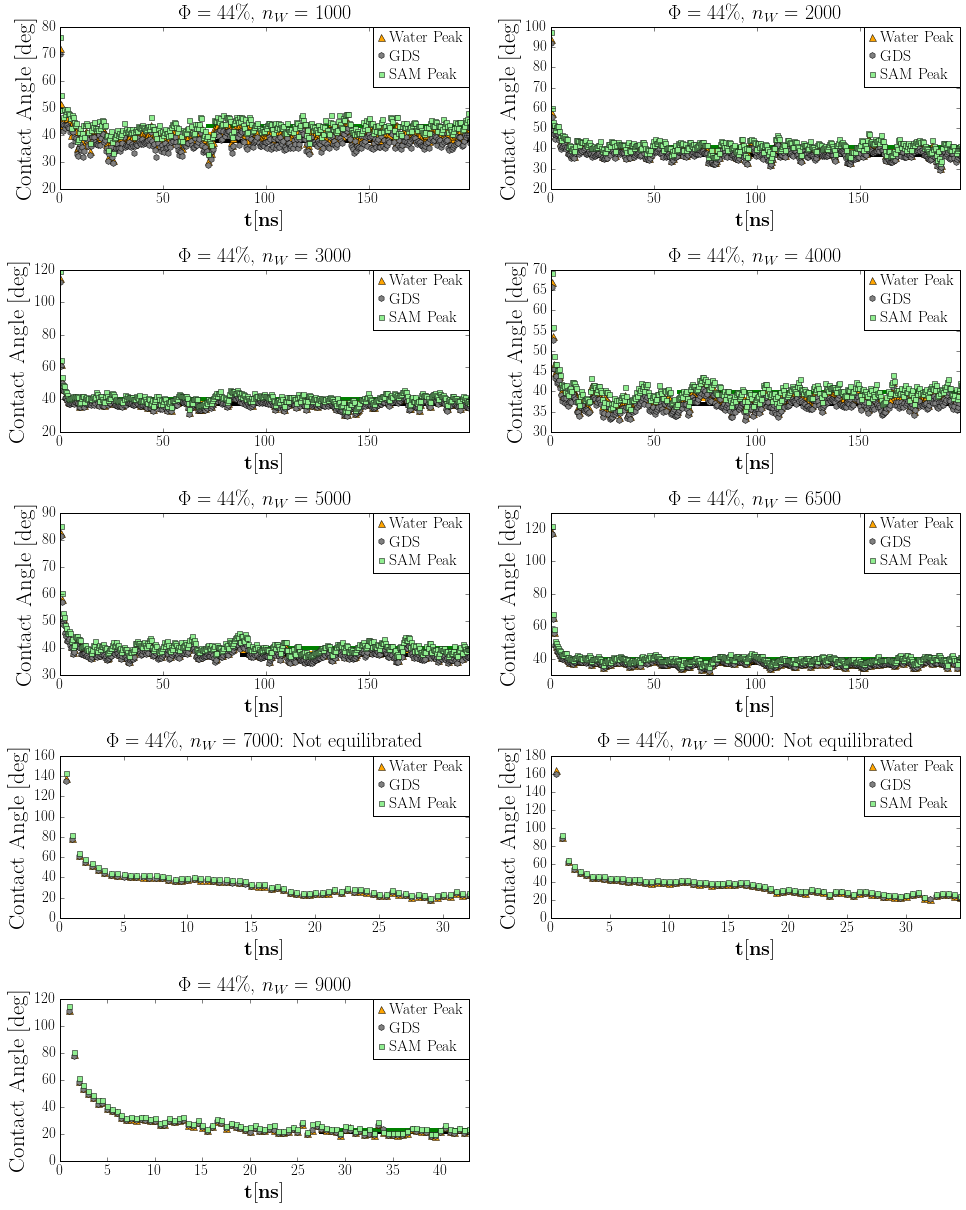

for SAM  44 % and  1000  molecules:
 Not equilibrated!
for SAM  44 % and  2000  molecules:
num of good intervals= 168
for SAM  44 % and  3000  molecules:
num of good intervals= 69
for SAM  44 % and  4000  molecules:
num of good intervals= 40
for SAM  44 % and  5000  molecules:
num of good intervals= 124
for SAM  44 % and  6500  molecules:
num of good intervals= 105
for SAM  44 % and  7000  molecules:
num of good intervals= 7
for SAM  44 % and  8000  molecules:
 Not equilibrated!
for SAM  44 % and  9000  molecules:
num of good intervals= 8


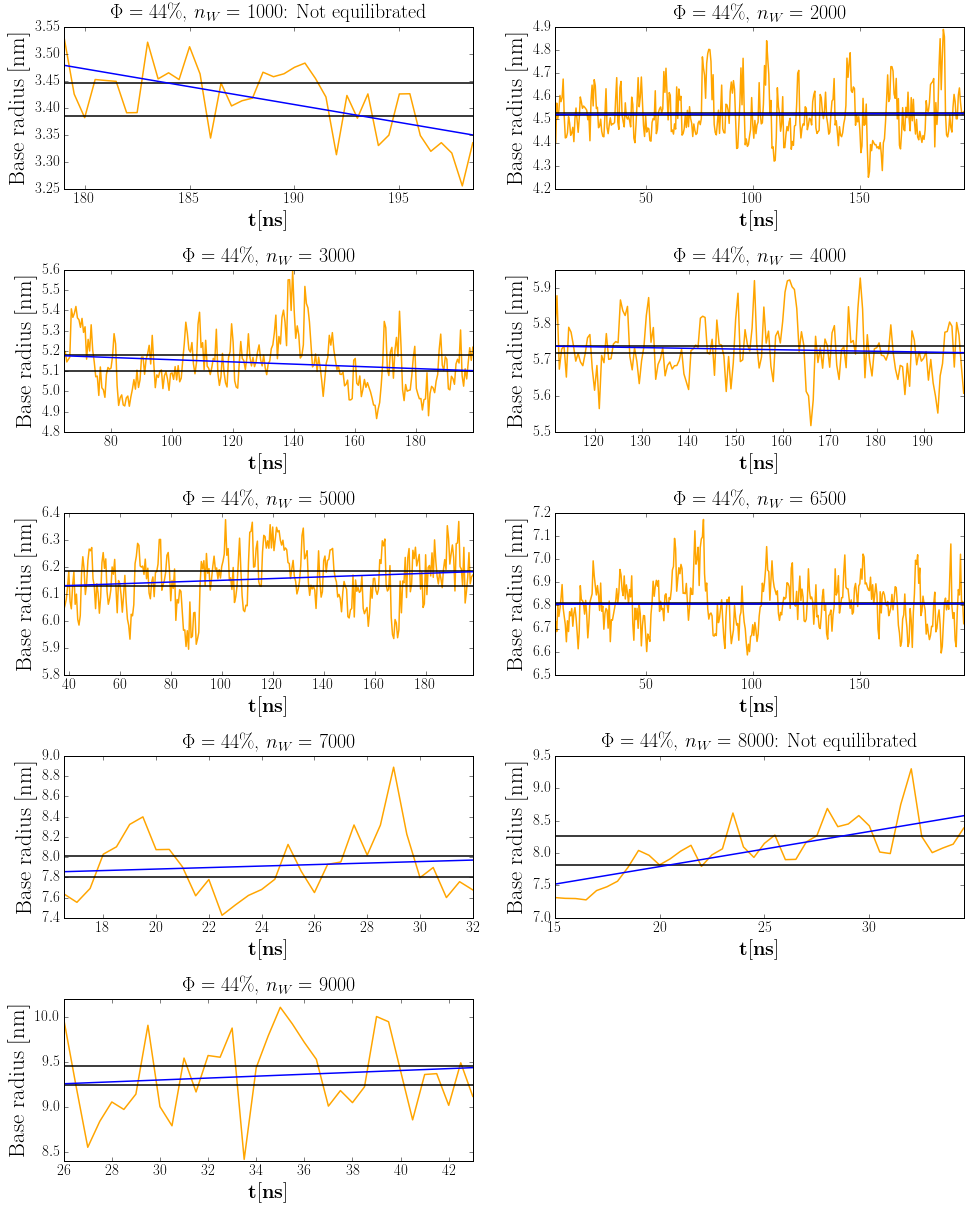

for SAM  44 % and  1000  molecules:
 Not equilibrated!
for SAM  44 % and  2000  molecules:
num of good intervals= 168
for SAM  44 % and  3000  molecules:
num of good intervals= 69
for SAM  44 % and  4000  molecules:
num of good intervals= 40
for SAM  44 % and  5000  molecules:
num of good intervals= 124
for SAM  44 % and  6500  molecules:
num of good intervals= 105
for SAM  44 % and  7000  molecules:
num of good intervals= 7
for SAM  44 % and  8000  molecules:
 Not equilibrated!
for SAM  44 % and  9000  molecules:
num of good intervals= 8


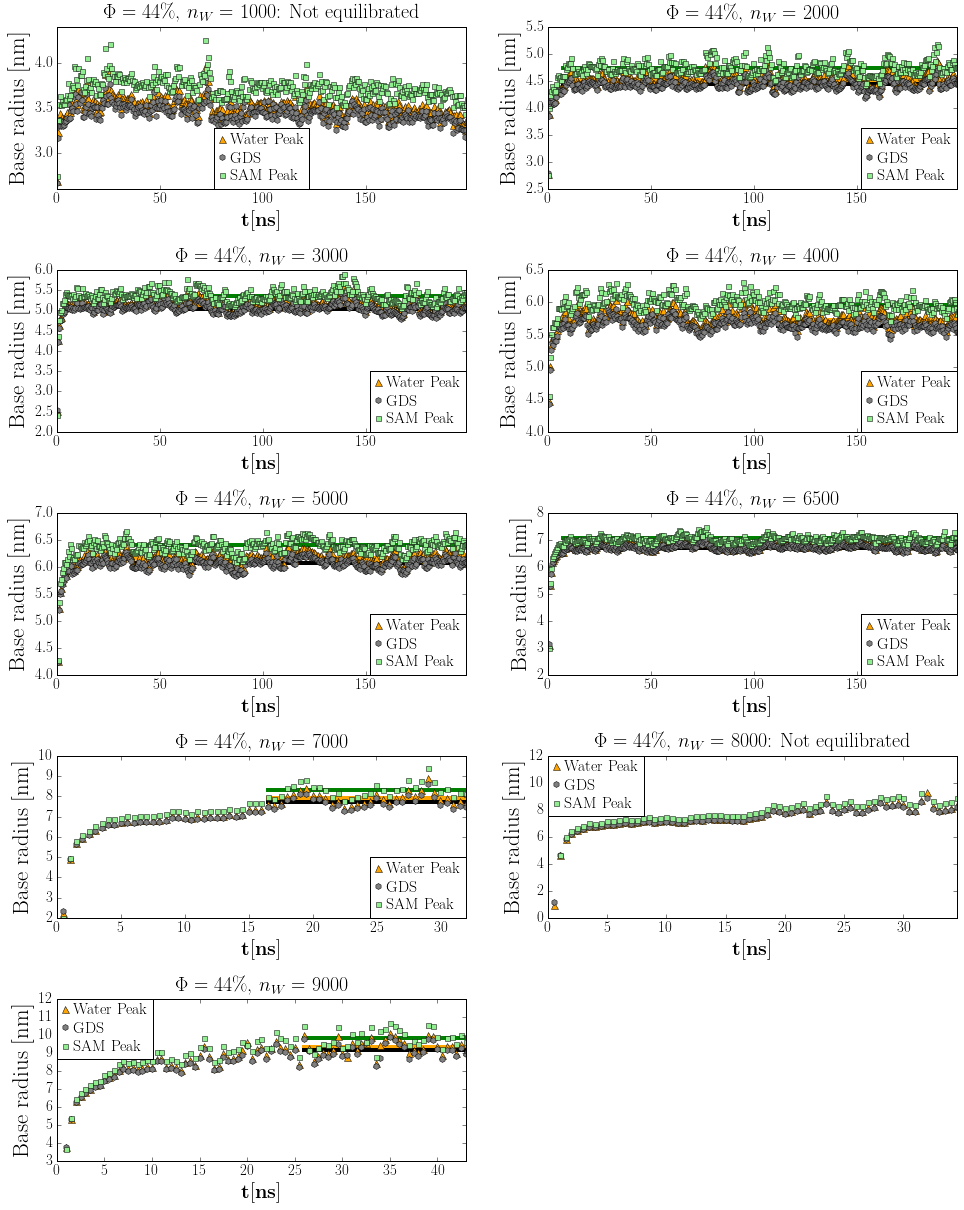

In [23]:
# Set parameters for plots of SAM with pc = 0%
pc=44

minblocksize=20 # The minimum block size is 10ns=20 points
beg = 10 # We leave out the first 5ns=10 points
blocksNum=3 #the function best_start uses also 3 blocks for averaging

Nrows = 5
Ncolumns = 2

loopvalues = Waters[44]

# Plot and analize Base Radii of equilibrated interval for GDS and SAM peak

theta_w[pc]=[] # microscopic contact angle of equilibrated system
errortheta_w[pc]=[] # error in the microscopic contact angle of equilibrated system
equil_theta_w[pc]=[] #equilibrated systems
#start_theta_w[pc]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_theta_w[pc]=[] # last t (time) of the simulation -> uncomment if needed

theta_w[pc],errortheta_w[pc],equil_theta_w[pc] = equil_results(loopvalues, angles_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, anglelabel, anglename)

# Plot and analize Contact Angles of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at MiddlePoint/GDS
errortheta_m[pc]=[]
theta_m[pc]=[]
equil_theta_m[pc]=[]
#start_theta_m[pc]=[] -> uncomment if needed
#end_theta_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
errortheta_s[pc]=[]
theta_s[pc]=[]
equil_theta_s[pc]=[]
#start_theta_s[pc]=[] -> uncomment if needed
#end_theta_s[pc]=[] -> uncomment if needed
    
theta_m[pc],errortheta_m[pc],equil_theta_m[pc],theta_s[pc],errortheta_s[pc],equil_theta_s[pc] =  whole_results(loopvalues, angles_w, angles_m, angles_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize,anglelabel, anglename)

# Plot and analize Base Radii of equilibrated interval for first water peak

error_rbase_w[pc]=[] # error in the microscopic contact angle of equilibrated system
rbase_w[pc]=[] # microscopic contact angle of equilibrated system
equil_rbase_w[pc]=[] #equilibrated systems
#start_rbase_w[b]=[] #first t (time) of the simulation with finite contact angle -> uncomment if needed
#end_rbase_w[b]=[] # last t (time) of the simulation -> uncomment if needed
    
rbase_w[pc],error_rbase_w[pc],equil_rbase_w[pc] = equil_results(loopvalues, radii_w, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

# Plot and analize Base Radii of equilibrated interval for MiddlePoint/GDS and SAM peak

# Interface at GDS
error_rbase_m[pc]=[]
rbase_m[pc]=[]
equil_rbase_m[pc]=[]
#start_rbase_m[pc]=[] -> uncomment if needed
#end_rbase_m[pc]=[] -> uncomment if needed

# Interface at SAM peak
error_rbase_s[pc]=[]
rbase_s[pc]=[]
equil_rbase_s[pc]=[]
#start_rbase_s[pc]=[] -> uncomment if needed
#end_rbase_s[pc]=[] -> uncomment if needed
    
rbase_m[pc],error_rbase_m[pc],equil_rbase_m[pc],rbase_s[pc],error_rbase_s[pc],equil_rbase_s[pc] =  whole_results(loopvalues, radii_w, radii_m, radii_s, pc, Nrows, Ncolumns, blocksNum, beg, t, minblocksize, radiuslabel, radiusname)

In [24]:
# Check number of equilibrated systems 
for i in SAMs:
    x = rbase_w[i]
    y = theta_w[i]
    print "WaterPeak: SAM",i,"%, len(rbase_w)=",len(x),"len(theta_w)=",len(y)
    x = rbase_m[i]
    y = theta_m[i]
    print "GDS: SAM",i,"%, len(rbase_m)=",len(x),"len(theta_m)=",len(y)
    x = rbase_s[i]
    y = theta_s[i]
    print "SAMPeak: SAM",i,"%, len(rbase_s)=",len(x),"len(theta_s)=",len(y),"\n"
    #if x.all() != 0:
        #x = 1/x
        #y = cos(radians(theta[i]))  

print equil_theta_w[33], equil_rbase_w[33]

WaterPeak: SAM 0 %, len(rbase_w)= 10 len(theta_w)= 10
GDS: SAM 0 %, len(rbase_m)= 10 len(theta_m)= 10
SAMPeak: SAM 0 %, len(rbase_s)= 10 len(theta_s)= 10 

WaterPeak: SAM 11 %, len(rbase_w)= 10 len(theta_w)= 10
GDS: SAM 11 %, len(rbase_m)= 10 len(theta_m)= 10
SAMPeak: SAM 11 %, len(rbase_s)= 10 len(theta_s)= 10 

WaterPeak: SAM 22 %, len(rbase_w)= 10 len(theta_w)= 10
GDS: SAM 22 %, len(rbase_m)= 10 len(theta_m)= 10
SAMPeak: SAM 22 %, len(rbase_s)= 10 len(theta_s)= 10 

WaterPeak: SAM 33 %, len(rbase_w)= 10 len(theta_w)= 10
GDS: SAM 33 %, len(rbase_m)= 10 len(theta_m)= 10
SAMPeak: SAM 33 %, len(rbase_s)= 10 len(theta_s)= 10 

WaterPeak: SAM 37 %, len(rbase_w)= 8 len(theta_w)= 8
GDS: SAM 37 %, len(rbase_m)= 8 len(theta_m)= 8
SAMPeak: SAM 37 %, len(rbase_s)= 8 len(theta_s)= 8 

WaterPeak: SAM 44 %, len(rbase_w)= 7 len(theta_w)= 7
GDS: SAM 44 %, len(rbase_m)= 7 len(theta_m)= 7
SAMPeak: SAM 44 %, len(rbase_s)= 7 len(theta_s)= 7 

[1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000, 10000]

In [25]:
# Equilibrated systems 
for i in SAMs:
    print equil_theta_w[i]

[1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000, 10000]
[1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000, 10000]
[1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000, 10000]
[1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000, 10000]
[1000, 2000, 4000, 5000, 6500, 7000, 8000, 9000]
[1000, 2000, 3000, 4000, 5000, 6500, 9000]


num of equilibrated systems =  10
num of equilibrated systems =  10
num of equilibrated systems =  10
num of equilibrated systems =  10
num of equilibrated systems =  8
num of equilibrated systems =  7


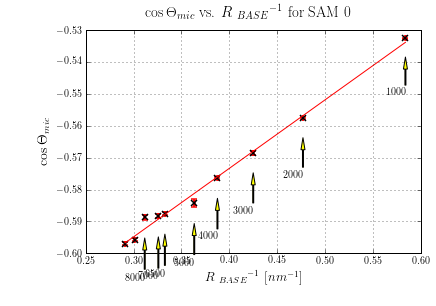

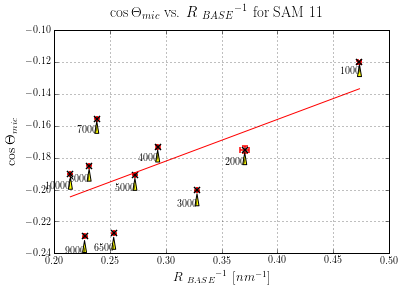

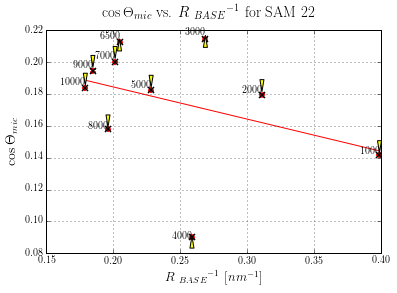

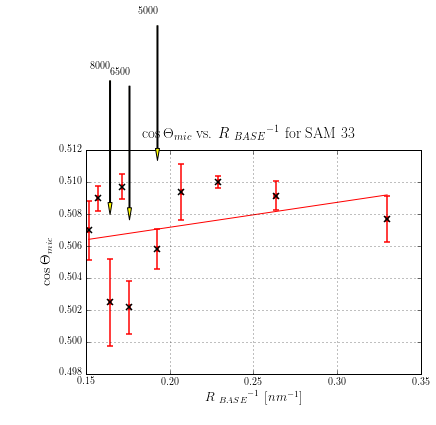

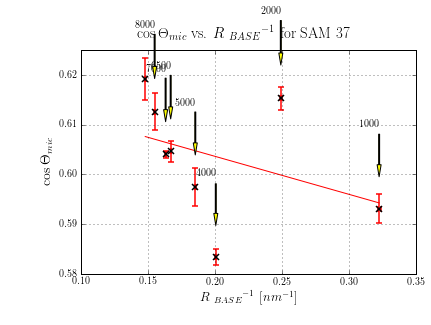

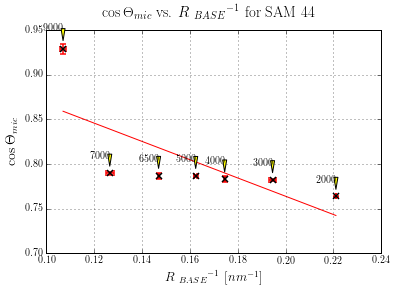

In [26]:
# Plot theta vs 1/Rbase with label for each system
for i in SAMs:
	x = []
	y = []
	x_error = []
	y_error = []
	mn=min(len(rbase_w[i]),len(theta_w[i]))
	print 'num of equilibrated systems = ', mn
	for j in range(mn):
		x.append(1/rbase_w[i][j])
		x_error.append((rbase_w[i][j]**(-2))*error_rbase_w[i][j])
		y.append(cos(radians(theta_w[i][j])))
		y_error.append(cos(radians(theta_w[i][j]))*radians(errortheta_w[i][j]))
	
	slope, intercept, delete1, delete2, delete3 = stats.linregress(x,y)

	yline=np.zeros(len(x))
	m=0
	for l in x:
		yline[m] = func(l, slope, intercept)
		m = m+1


	# PLOT INSTEAD OF SUBPLOT
	plt.figure()
	plt.errorbar(x, y, xerr=x_error, yerr=y_error,fmt='x', ecolor='red',elinewidth=1.5, color='black',markeredgewidth=1.5)
	plt.plot(x, yline, color='r')

	plt.xlabel('${R \ _{BASE}}^{-1}\ [ nm ^{-1} ]$',fontsize=13)
	plt.ylabel(r' $\cos\Theta_{mic}$ ',fontsize=14)
	mytitle = plt.suptitle(r'$\cos\Theta_{mic}$ vs. ${R \ _{BASE}}^{-1}$ for SAM '+str(i)+'%', fontsize=15,fontweight='bold')

	# Labels next to each point
	for j in range(mn):
		xarrow = x[j]
		yarrow =y[j] + ((y[j])*0.01)
		xtext = x[j]
		ytext = y[j] + ((y[j])*0.03)
		plt.annotate(str(equil_rbase_w[i][j]), xy=(xarrow,yarrow), xytext=(xtext,ytext),arrowprops=dict(facecolor='yellow', shrink=0.05,
																									  width=1, headwidth=4),
					horizontalalignment='right', verticalalignment='top',)
		#ax.annotate(str(equil_rbase[i][j]), xytext=(xtext,ytext), xy=(xarrow,yarrow),horizontalalignment='right', verticalalignment='top',)
	
	plt.grid(True)
	#plt.axis([0.3, 0.9, -1.0, 0.0])
	#plt.show()
	plt.savefig('s'+str(i)+'_cos_r.jpg',bbox_extra_artists=(mytitle,), bbox_inches='tight')

SAM 0
10 [1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000, 10000]
SAM 11
10 [1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000, 10000]
SAM 22
10 [1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000, 10000]
SAM 33
10 [1000, 2000, 3000, 4000, 5000, 6500, 7000, 8000, 9000, 10000]
SAM 37
8 [1000, 2000, 4000, 5000, 6500, 7000, 8000, 9000]
SAM 44
7 [2000, 3000, 4000, 5000, 6500, 7000, 9000]


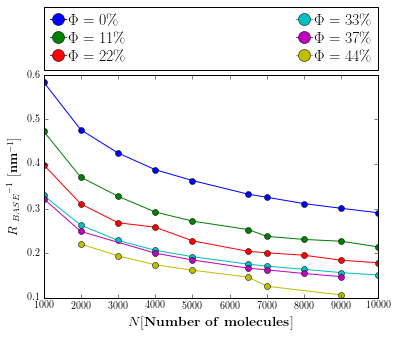

In [27]:
# Plot 1/Rbase vs N (num molecs)
for i in SAMs:
    
    x = []
    mn=len(rbase_w[i])
    for j in range(mn):
        x.append(1/rbase_w[i][j])
    
    print "SAM",i
    print len(equil_rbase_w[i]),equil_rbase_w[i]
    
    text = r'$\Phi=\ $'+str(i)
    plt.plot(equil_rbase_w[i],x,'o-',label = text + '\%')

    x2 = np.linspace(equil_rbase_w[i][0], equil_rbase_w[i][mn-1],500)    
    #myfunction2_w = interp1d(sorted(equil_rbase_w[i]),x, kind='cubic') 
    #plt.plot(x2,myfunction2_w(x2))
    
    
art = []    
mylegend=plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
        ncol=2, mode="expand", borderaxespad=0.,fontsize=16)
art.append(mylegend)
plt.ylabel('${R \ _{BASE}}^{-1}\ [ \mathbf{nm} ^{-1} ]$',fontsize=13)
plt.xlabel('$N [ \mathbf{Number \ of \ molecules}]$',fontsize=14)
 
plt.savefig('radius-1_N_dependence.png',additional_artists=art, bbox_inches='tight', transparent=False)

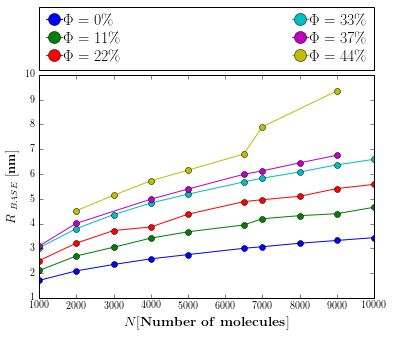

In [28]:
# Plot Rbase vs N (num molecs)
for i in SAMs:
    
    text = r'$\Phi=\ $'+str(i)
    plt.plot(equil_rbase_w[i],rbase_w[i],'o-',label = text + '\%')

    #x2 = np.linspace(equil_rbase_w[i][0], equil_rbase_w[i][mn-1],500)    
    #myfunction2_w = interp1d(sorted(equil_rbase_w[i]),x, kind='cubic') 
    #plt.plot(x2,myfunction2_w(x2))
    
art = []    
mylegend=plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
        ncol=2, mode="expand", borderaxespad=0.,fontsize=16)
art.append(mylegend)
plt.ylabel('${R \ _{BASE}}\ [ \mathbf{nm} ]$',fontsize=13)
plt.xlabel('$N [ \mathbf{Number \ of \ molecules}]$',fontsize=14)
 
plt.savefig('radius_N_dependence.png',bbox_inches='tight',additional_artists=art, transparent=False)

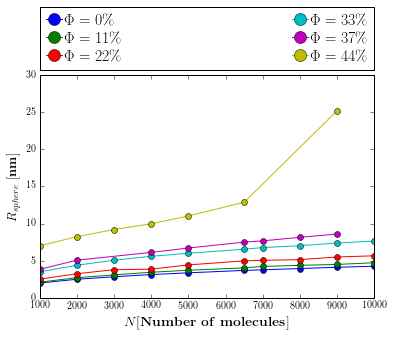

In [29]:
# Plot Rsphere vs N (num molecs)
for i in SAMs:
    sphereR = []
    for j in range(len(theta_w[i])):
        sphereR.append(rbase_w[i][j]/np.cos(radians(theta_w[i][j]-90)))
    
    text = r'$\Phi=\ $'+str(i)
    plt.plot(equil_theta_w[i],sphereR,'o-',label = text + '\%')

    #x2 = np.linspace(equil_rbase_w[i][0], equil_rbase_w[i][mn-1],500)    
    #myfunction2_w = interp1d(sorted(equil_rbase_w[i]),x, kind='cubic') 
    #plt.plot(x2,myfunction2_w(x2))
    
art = []    
mylegend=plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
        ncol=2, mode="expand", borderaxespad=0.,fontsize=16)
art.append(mylegend)
plt.ylabel('${R_{sphere}}\ [ \mathbf{nm} ]$',fontsize=13)
plt.xlabel('$N [ \mathbf{Number \ of \ molecules}]$',fontsize=14)
 
plt.savefig('sphereRadius_N_dependence.png',bbox_inches='tight',additional_artists=art, transparent=False)

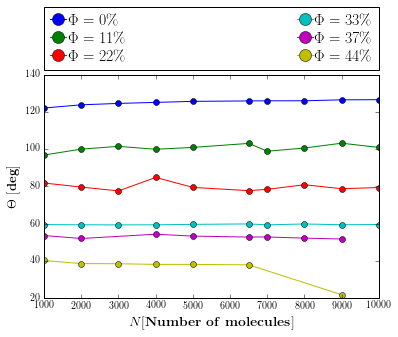

In [30]:
# Plot microscopic theta vs N (num molecs)
for i in SAMs:
    
    text = r'$\Phi=\ $'+str(i)
    plt.plot(equil_theta_w[i],theta_w[i],'o-',label = text + '\%')
       
art = []    
mylegend=plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
        ncol=2, mode="expand", borderaxespad=0.,fontsize=16)
art.append(mylegend)
plt.ylabel('$ \Theta \ [ \mathbf{deg} ]$',fontsize=13)
plt.xlabel('$N [ \mathbf{Number \ of \ molecules}]$',fontsize=14)
 
plt.savefig('theta_N_dependence.png',additional_artists=art, bbox_inches='tight', transparent=False)

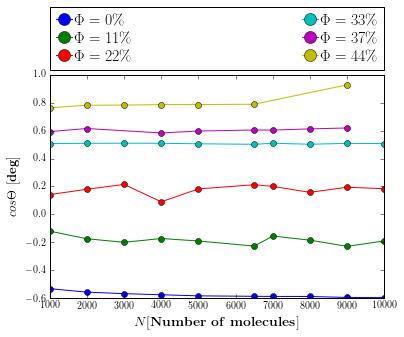

In [31]:
# Plot cos(microscopic theta) vs N (num molecs)
for i in SAMs:
    
    text = r'$\Phi=\ $'+str(i)
    plt.plot(equil_theta_w[i],np.cos(radians(theta_w[i])),'o-',label = text + '\%')
       
art = []    
mylegend=plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
        ncol=2, mode="expand", borderaxespad=0.,fontsize=16)
art.append(mylegend)
plt.ylabel('$ cos \Theta \ [ \mathbf{deg} ]$',fontsize=13)
plt.xlabel('$N [ \mathbf{Number \ of \ molecules}]$',fontsize=14)
 
plt.savefig('cos_theta_N_dependence.png',additional_artists=art, bbox_inches='tight', transparent=False)

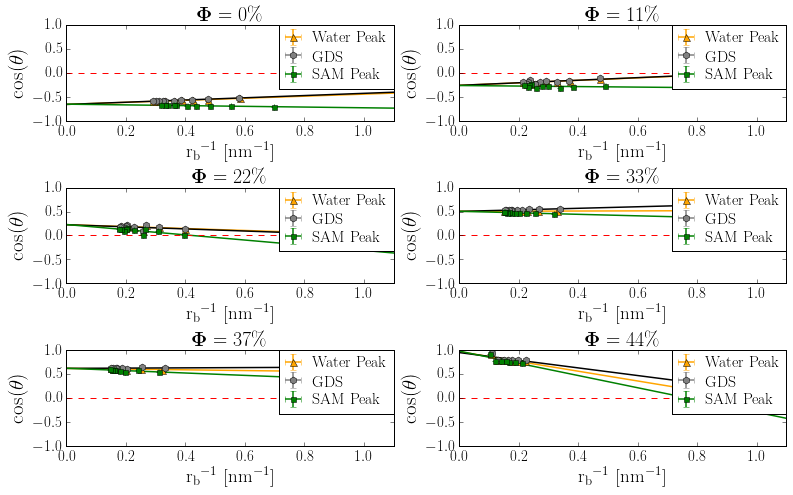

In [32]:
# WITH ERRORBARS: PLOTS USING SAME AXIS LENGTHS FOR THE 3 DEFINITIONS OF Z=0

slopes_all_w=[]
intercepts_all_w=[]
slopes_all_m=[]
intercepts_all_m=[]
slopes_all_s=[]
intercepts_all_s=[]

line1=[]
line2=[]
line3=[]
line4=[]

Nrows = 4
Ncolumns = 2
fig, ax = plt.subplots(Ncolumns, Nrows,figsize=(5,1.8))
fig.subplots_adjust(bottom=0.0,top=1.5, left=0.0, right=2, hspace = 0.7)
matplotlib.rcParams['legend.handlelength'] = 1  #the length of the legend handles
matplotlib.rcParams['legend.markerscale'] = 1.5
matplotlib.rcParams['legend.handletextpad'] = 0.7 #the pad between the legend handle and text
matplotlib.rcParams['font.family'] = 'Times New Roman'
#rcParams['legend.numpoints'] = 1

k = 0
for i in SAMs:
    ax = plt.subplot(Nrows, Ncolumns, k+1)
    x_w = []
    y_w = []
    x_error_w = []
    y_error_w = []
    
    #mn=min(len(rbase_w[i]),len(theta_w[i]))
    mn=len(theta_w[i])
    for j in range(mn):
        x_w.append(1/rbase_w[i][j])
        x_error_w.append((rbase_w[i][j]**(-2))*error_rbase_w[i][j])
        y_w.append(cos(radians(theta_w[i][j])))
        y_error_w.append(cos(radians(theta_w[i][j]))*radians(errortheta_w[i][j])) 
    slope, intercept, delete1, delete2, delete3 = stats.linregress(x_w,y_w)
    slopes_all_w.append(slope)
    intercepts_all_w.append(intercept)
    m=0
    l_w=arange(0,1.3,0.1)
    yline_w=np.zeros(len(l_w))
    for l in l_w:
        yline_w[m] = func(l, slope, intercept)
        m = m+1

    x_m = []
    y_m = []
    x_error_m = []
    y_error_m = [] 
    #mn=min(len(rbase_m[i]),len(theta_m[i]))
    mn=len(theta_m[i])
    for j in range(mn):
        x_m.append(1/rbase_m[i][j])
        x_error_m.append((rbase_m[i][j]**(-2))*error_rbase_m[i][j])
        y_m.append(cos(radians(theta_m[i][j])))
        y_error_m.append(cos(radians(theta_m[i][j]))*radians(errortheta_m[i][j]))
    slope, intercept, delete1, delete2, delete3 = stats.linregress(x_m,y_m)
    slopes_all_m.append(slope)
    intercepts_all_m.append(intercept)
    m=0
    l_m=arange(0,1.3,0.1)
    yline_m=np.zeros(len(l_m))
    for l in l_m:
        yline_m[m] = func(l, slope, intercept)
        m = m+1
    
    x_s = []
    y_s = []
    x_error_s = []
    y_error_s = []
    #mn=min(len(rbase_s[i]),len(theta_s[i]))
    mn=len(theta_s[i])
    for j in range(mn):
        x_s.append(1/rbase_s[i][j])
        x_error_s.append((rbase_s[i][j]**(-2))*error_rbase_s[i][j])
        y_s.append(cos(radians(theta_s[i][j])))
        y_error_s.append(cos(radians(theta_s[i][j]))*radians(errortheta_s[i][j]))
    slope, intercept, delete1, delete2, delete3 = stats.linregress(x_s,y_s)
    slopes_all_s.append(slope)
    intercepts_all_s.append(intercept)        
    m=0
    #for l in max(x_s):
    l_s=arange(0,1.3,0.1)
    yline_s=np.zeros(len(l_s))
    for l in l_s:
        yline_s[m] = func(l, slope, intercept)
        m = m+1

    #plot of the data points
    line2, = ax.plot(l_w, yline_w,'c',color='orange', linewidth=1.5)
    line3, = ax.plot(l_m, yline_m ,color='black',linewidth=1.5)
    line4, = ax.plot(l_s, yline_s,'g',linewidth=1.5)
    
    #plot of a black line through y=0
    zeropoints=np.zeros(len(l_w))
    ax.plot(l_w, zeropoints,'r--')

    #plots of errorbars
    ax.errorbar(x_w, y_w,xerr=x_error_w, yerr=y_error_w, fmt='^',color='orange',markersize=7,linewidth=1.5,label='Water Peak')
    ax.errorbar(x_m, y_m,xerr=x_error_m, yerr=y_error_m, fmt='h',color='gray',markersize=7,linewidth=1.5,label='GDS')
    ax.errorbar(x_s, y_s,xerr=x_error_s, yerr=y_error_s, fmt='gs',markersize=5,linewidth=1.5,label='SAM Peak')
    #other options for errorbars: ecolor='red',elinewidth=1.5, color='red',markeredgewidth=1.5
    
    ax.set_xlim([0,1.1])
    ax.set_ylim([-1,+1])

    # Set bold labels
    #ax.set_xlabel(r'$\mathbf{{r_{b}}^{-1}\ [ nm ^{-1} ]}$',fontsize=19)
    #ax.set_ylabel(r'$\mathbf{cos(\theta)}$',fontsize=19)
    
    # Non-bold labels
    ax.set_xlabel(r'$\mathrm{{r_{b}}^{-1}\ [ nm ^{-1} ]}$',fontsize=19)
    ax.set_ylabel(r'$\mathrm{cos(\theta)}$',fontsize=21)
    
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):item.set_fontsize(15)
    
    #titles for each subplot:
    mysubtitle=ax.set_title('$\mathbf{\Phi= \ }$'+str(i)+'\%',fontweight='bold',fontsize=20)
    plt.setp(mysubtitle, color='black')         #set the color of title to white
    
    # Create a legend for the first line.
    first_legend = plt.legend(loc=1,borderaxespad=0.,markerscale=1,fontsize=16)
    # Add the legend manually to the current Axes.
    ax = plt.gca().add_artist(first_legend)
    
    
    # Set size of subplots
    fig.subplots_adjust(top=4.5) 
    
    #plt.grid(True)
    k = k + 1

#titletext='On the Same Scale: '+ r'$cos(\theta_{mic})$' +' vs 1/R$\ _{BASE} $ for Three Definitions \n OF $z=0$ Together with Pressure Tensor Results'
#mytitle = plt.suptitle(titletext, fontsize=20, fontweight='bold', x=1.0, y=4.7)

plt.show()
fig.savefig('all_cos_r_zoom.pdf',bbox_extra_artists=(first_legend,mysubtitle,), bbox_inches='tight', dpi=400)

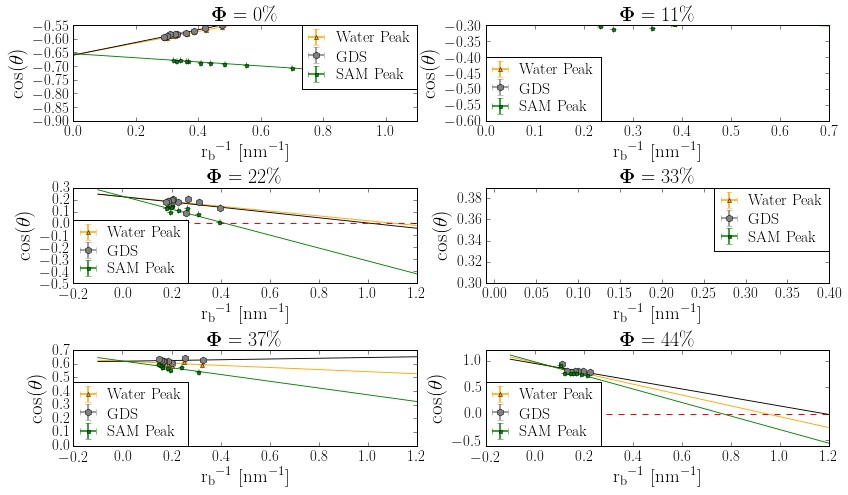

In [33]:
# WITH ERRORBARS: PLOTS SCALED EQUALLY WITH PRESSURE TENSOR RESULTS AND 3 DEFINITIONS OF Z=0
#(for the 3 def. of z=0)
slopes_all_w=[]
intercepts_all_w=[]
slopes_all_m=[]
intercepts_all_m=[]
slopes_all_s=[]
intercepts_all_s=[]

line1=[]
line2=[]
line3=[]
line4=[]

Nrows = 4
Ncolumns = 2
fig, ax = plt.subplots(Ncolumns, Nrows ,figsize=(5,1.8),dpi=400)
fig.subplots_adjust(bottom=0.0,top=1.5, left=0.0, right=2.1, hspace = 0.7)

matplotlib.rcParams['legend.handlelength'] = 1  #the length of the legend handles
#matplotlib.rcParams['legend.markerscale'] = 1.5
matplotlib.rcParams['legend.handletextpad'] = 0.7 #the pad between the legend handle and text
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.markerscale'] = 1.5


k = 0
for i in SAMs:
    ax = plt.subplot(Nrows, Ncolumns, k+1)
    x_w = []
    y_w = []
    x_error_w = []
    y_error_w = []
    #mn=min(len(rbase_w[i]),len(theta_w[i]))
    mn=len(theta_w[i])
    for j in range(mn):
        x_w.append(1/rbase_w[i][j])
        x_error_w.append((rbase_w[i][j]**(-2))*error_rbase_w[i][j])
        y_w.append(cos(radians(theta_w[i][j])))
        y_error_w.append(cos(radians(theta_w[i][j]))*radians(errortheta_w[i][j])) 
    slope, intercept, delete1, delete2, delete3 = stats.linregress(x_w,y_w)
    slopes_all_w.append(slope)
    intercepts_all_w.append(intercept)
    m=0
    l_w=arange(-0.1,1.3,0.1)
    yline_w=np.zeros(len(l_w))
    for l in l_w:
        yline_w[m] = func(l, slope, intercept)
        m = m+1

    x_m = []
    y_m = []
    x_error_m = []
    y_error_m = [] 
    #mn=min(len(rbase_m[i]),len(theta_m[i]))
    mn=len(theta_m[i])
    for j in range(mn):
        x_m.append(1/rbase_m[i][j])
        x_error_m.append((rbase_m[i][j]**(-2))*error_rbase_m[i][j])
        y_m.append(cos(radians(theta_m[i][j])))
        y_error_m.append(cos(radians(theta_m[i][j]))*radians(errortheta_m[i][j]))
    slope, intercept, delete1, delete2, delete3 = stats.linregress(x_m,y_m)
    slopes_all_m.append(slope)
    intercepts_all_m.append(intercept)
    m=0
    l_m=arange(-0.1,1.3,0.1)
    yline_m=np.zeros(len(l_m))
    for l in l_m:
        yline_m[m] = func(l, slope, intercept)
        m = m+1
    
    x_s = []
    y_s = []
    x_error_s = []
    y_error_s = []
    #mn=min(len(rbase_s[i]),len(theta_s[i]))
    mn=len(theta_s[i])
    for j in range(mn):
        x_s.append(1/rbase_s[i][j])
        x_error_s.append((rbase_s[i][j]**(-2))*error_rbase_s[i][j])
        y_s.append(cos(radians(theta_s[i][j])))
        y_error_s.append(cos(radians(theta_s[i][j]))*radians(errortheta_s[i][j]))
    slope, intercept, delete1, delete2, delete3 = stats.linregress(x_s,y_s)
    slopes_all_s.append(slope)
    intercepts_all_s.append(intercept)        
    m=0
    #for l in max(x_s):
    l_s=arange(-0.1,1.3,0.1)
    yline_s=np.zeros(len(l_s))
    for l in l_s:
        yline_s[m] = func(l, slope, intercept)
        m = m+1
    if intercept<0:
        signtext='x'
    else:
        signtext='x+'

    #plot of the data points   
    ax.plot(l_w, yline_w,'c',color='orange', linewidth=0.9) #1.5
    ax.plot(l_m, yline_m ,color='black',linewidth=0.9)
    ax.plot(l_s, yline_s,'g',linewidth=0.9)
    
    #plot of a black line through y=0
    zeropoints=np.zeros(len(l_w))
    ax.plot(l_w, zeropoints,'r--')

    #plots of errorbars
    ax.errorbar(x_w, y_w,xerr=x_error_w, yerr=y_error_w, fmt='^',color='orange',markersize=4,linewidth=1.5,label='Water Peak')
    ax.errorbar(x_m, y_m,xerr=x_error_m, yerr=y_error_m, fmt='h',color='gray',markersize=7,linewidth=1.5,label='GDS')
    ax.errorbar(x_s, y_s,xerr=x_error_s, yerr=y_error_s, fmt='gs',markersize=3,linewidth=1.5,label='SAM Peak')
    #other options for errorbars: ecolor='red',elinewidth=1.5, color='red',markeredgewidth=1.5

            
    if i==0:
        ax.set_xlim([0,1.1])
        ax.set_ylim([-0.9,-0.55])
    elif i==5:
        ax.set_xlim([0.05,0.5])
        ax.set_ylim([-0.85,-0.5])
    elif i==11:
        ax.set_xlim([0,0.7])
        ax.set_ylim([-0.6,-0.3])
    elif i==17:
        ax.set_xlim([0.01,0.45])
        ax.set_ylim([-0.36,-0.18])
    elif i==21:
        ax.set_xlim([0,0.32])
        ax.set_ylim([-0.3,0.2])
    elif i==25:
        ax.set_xlim([-0.01,0.33])
        ax.set_ylim([-0.13,0.05])
    elif i==33:
        ax.set_xlim([-0.01,0.4])
        ax.set_ylim([0.30,0.39])
    elif i==41:
        ax.set_xlim([-0.01,0.27])
        ax.set_ylim([0.085,0.165])


    # Set bold labels
    #ax.set_xlabel(r'$\mathbf{{R_{BASE}}^{-1}\ [ nm ^{-1} ]}$',fontsize=15)
    #ax.set_ylabel(r'$\mathbf{cos(\theta_{mic})}$',fontsize=19)
    
    # Set non-bold labels
    ax.set_xlabel(r'$\mathrm{{r_{b}}^{-1}\ [ nm ^{-1} ]}$',fontsize=19)
    ax.set_ylabel(r'$\mathrm{cos(\theta)}$',fontsize=21)
    
    #for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):item.set_fontsize(15)

    for item in (ax.get_xticklabels() + ax.get_yticklabels()):item.set_fontsize(15)
    
    #titles for each subplot:
    mysubtitle=ax.set_title('$\mathbf{\Phi= \ }$'+str(i)+'\%',fontweight='bold',fontsize=20)
    plt.setp(mysubtitle, color='black')         #set the color of title to white
    
    # Create a legend for the first line.
    first_legend = plt.legend(loc=0,borderaxespad=0.,markerscale=1,fontsize=16)
    # Add the legend manually to the current Axes.
    ax = plt.gca().add_artist(first_legend)    
    
    # Set size of subplots
    fig.subplots_adjust(top=4.5) 
    
    k = k + 1

plt.show()    
fig.savefig('scaled_errors_all_cos_r.jpg',format='pdf', bbox_inches='tight',dpi=400)

In [34]:
# WE CALCULATE THE MACROSCOPIC CONTACT ANGLES (theta_mac_w in radians) AND THE LINE TENSIONS (sigma_w)

theta_mac_w=np.zeros(len(intercepts_all_w))
sigma_w=np.zeros(len(slopes_all_w))
for i in range(len(intercepts_all_w)):
    theta_mac_w[i]=arccos(intercepts_all_w[i])
    sigma_w[i]=(-52.7)*slopes_all_w[i]
print "theta_mac_w", theta_mac_w
print "sigma_w",sigma_w

theta_mac_m=np.zeros(len(intercepts_all_m))
sigma_m=np.zeros(len(slopes_all_m))
for i in range(len(intercepts_all_m)):
    theta_mac_m[i]=arccos(intercepts_all_m[i])
    sigma_m[i]=(-52.7)*slopes_all_m[i]
print "theta_mac_m",theta_mac_m
print "sigma_m",sigma_m

theta_mac_s=np.zeros(len(intercepts_all_s))
sigma_s=np.zeros(len(slopes_all_s))
for i in range(len(intercepts_all_s)):
    theta_mac_s[i]=arccos(intercepts_all_s[i])
    sigma_s[i]=(-52.7)*slopes_all_s[i]
print "theta_mac_s",theta_mac_s
print "sigma_s",sigma_s

theta_mac_w [ 2.29055432  1.83448902  1.34411686  1.04251921  0.90336496  0.25108628]
sigma_w [-11.3129819  -13.78560348  10.63533498  -0.82389116   4.03569895
  53.91964014]
theta_mac_m [ 2.29164531  1.83443937  1.3449495   1.04466324  0.90343353  0.32037235]
sigma_m [-12.24873629 -14.15440311  11.59785199  -8.56321347  -1.4356188
  42.21042005]
theta_mac_s [ 2.28443708  1.83829875  1.34086843  1.04189734  0.90113567  0.19837761]
sigma_s [  3.96586162   2.90445095  28.5464129    8.31695981  13.04542979
  67.37983676]


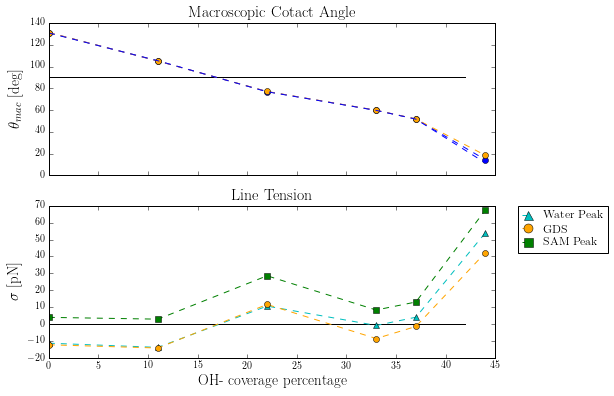

In [35]:
#plots without complete wetting results
# Two subplots, unpack the axes array immediately
fig, axarr = plt.subplots(2, sharex=True,figsize=(8,6), dpi=400)
rcParams['figure.figsize'] = 8, 6 #size of plots

# we mark the zero point with a line
zerox=range(43)
linezero=np.zeros(43)
axarr[1].plot(zerox,linezero,'k-')

# we mark the 90 deg. point with a line for the contact angle
zerox=range(43)
lineninety=43*[90]
axarr[0].plot(zerox,lineninety,'k-')

axarr[0].plot(SAMs,degrees(theta_mac_w),'bo--')
axarr[0].plot(SAMs,degrees(theta_mac_m),'o--', color='orange')
axarr[0].plot(SAMs,degrees(theta_mac_s),'--')
mytitle1=axarr[0].set_title('Macroscopic Cotact Angle',fontsize=16, fontweight='bold')

axarr[1].plot(SAMs,sigma_w,'c^--',label="Water Peak")
axarr[1].plot(SAMs,sigma_m,'o--', color='orange',label="GDS")
axarr[1].plot(SAMs,sigma_s,'gs--',label="SAM Peak")
axarr[1].set_title('Line Tension',fontsize=16, fontweight='bold')

axarr[0].set_ylabel(r'$\theta_{mac}$ [deg]',fontsize=15)
axarr[1].set_ylabel('$\sigma$ [pN]',fontsize=15)
axarr[1].set_xlabel('OH- coverage percentage',fontsize=15)

first_legend=axarr[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
fig.savefig('subplt_alltheta_mac_sigma2.jpg',bbox_extra_artists=(first_legend,mytitle1,), bbox_inches='tight')

In [36]:
# we add the results of SAM 50% and SAM 60% to sigma (in sigma2) and to theta_mac (in theta_mac2)
# and change all the types to list (incl. percentages-> percentages2)

sigma2_w=list(sigma_w)
sigma2_w=sigma2_w+[0]
print sigma2_w

theta_mac2_w=list(theta_mac_w)
theta_mac2_w=theta_mac2_w+[0]
print theta_mac2_w

sigma2_m=list(sigma_m)
sigma2_m=sigma2_m+[0]
print sigma2_m

theta_mac2_m=list(theta_mac_m)
theta_mac2_m=theta_mac2_m+[0]
print theta_mac2_m

sigma2_s=list(sigma_s)
sigma2_s=sigma2_s+[0]
print sigma2_s

theta_mac2_s=list(theta_mac_s)
theta_mac2_s=theta_mac2_s+[0]
print theta_mac2_s

percentages2=list(percentages)
print percentages2

[-11.312981900305976, -13.785603477497814, 10.635334980681403, -0.82389115984968708, 4.0356989484789052, 53.919640143256785, 0]
[2.2905543205343832, 1.8344890184627221, 1.3441168588429866, 1.0425192135853181, 0.9033649553305273, 0.25108627525696964, 0]
[-12.248736290340352, -14.154403110379803, 11.597851985781515, -8.5632134680426457, -1.4356187967828982, 42.210420051004029, 0]
[2.2916453129233902, 1.8344393728487951, 1.3449495036134134, 1.044663236290416, 0.90343352627162776, 0.3203723513421336, 0]
[3.965861615958882, 2.9044509521077599, 28.546412902644565, 8.3169598052193745, 13.045429791212319, 67.379836757525794, 0]
[2.2844370825253408, 1.8382987508977731, 1.3408684318208839, 1.0418973410392767, 0.90113567102225867, 0.19837761179859073, 0]
[0, 11, 22, 33, 37, 44, 50]


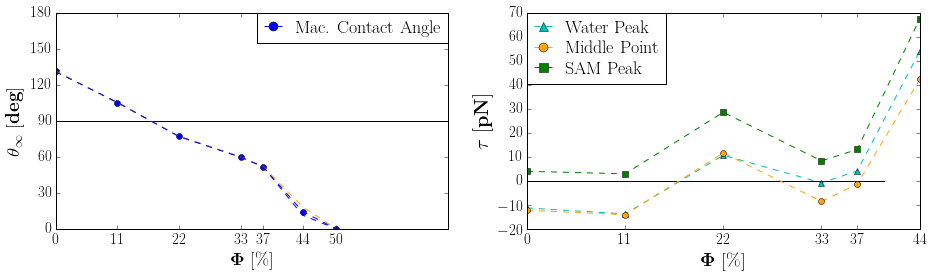

In [37]:
# This plot is done to get the 2 plots side by side, because otherwise Latex makes the figures so small 
# that the axes cannot be distinguisehd anymore.
fig = plt.figure()
fig.subplots_adjust(bottom=0.0,top=0.5, left=0, right=1.5, hspace = 0.5)

axarr0 = fig.add_subplot(121)

# we mark the 90 deg. point with a line for the contact angle
zerox=range(71)
lineninety=71*[90]
axarr0.plot(zerox,lineninety,'k-')

axarr0.plot(percentages2,degrees(theta_mac2_w),'bo--',label='Mac. Contact Angle')
axarr0.plot(percentages2,degrees(theta_mac2_m),'--', color='orange')
axarr0.plot(percentages2,degrees(theta_mac2_s),'--')
#mytitle1=axarr0.set_title('Macroscopic Cotact Angle',fontsize=16, fontweight='bold')
axarr0.set_ylabel(r'$\mathbf{\theta_{\infty} \ [deg]}$',fontsize=19)
axarr0.set_xlabel(r'$\mathbf{\Phi} \ [\%]$',fontsize=18)
axarr0.set_xticks(percentages2)
axarr0.set_yticks([0,30,60,90,120,150,180])

#line2, =axarr[0].plot(percentages2,ptensor,'rs--',label='Pressure Tensor Method')
axarr1 = fig.add_subplot(122)

# we mark the zero point with a line for the line tension
zerox=range(41)
linezero=np.zeros(41)
axarr1.plot(zerox,linezero,'k-')

axarr1.plot(SAMs,sigma_w,'c^--',label="Water Peak")
axarr1.plot(SAMs,sigma_m,'o--', color='orange',label="Middle Point")
axarr1.plot(SAMs,sigma_s,'gs--',label="SAM Peak")
#axarr1.set_title('Line Tension',fontsize=16, fontweight='bold')

axarr1.set_ylabel(r'$\mathbf{\tau \ [pN]}$',fontsize=20)
axarr1.set_xlabel(r'$\mathbf{\Phi} \ [\%]$',fontsize=19)
axarr1.set_xlim([0,33])
axarr1.set_xticks(SAMs)

for item in (axarr0.get_xticklabels() + axarr0.get_yticklabels() + axarr1.get_xticklabels() + axarr1.get_yticklabels()):item.set_fontsize(15)
    
first_legend=axarr1.legend(loc=0, borderaxespad=0.,fontsize=18)
second_legend=axarr0.legend(loc=0, borderaxespad=0.,fontsize=18)

plt.show()
fig.savefig('subplt_theta_mac_tau.jpg',bbox_extra_artists=(first_legend,second_legend,), bbox_inches='tight', dpi=400)

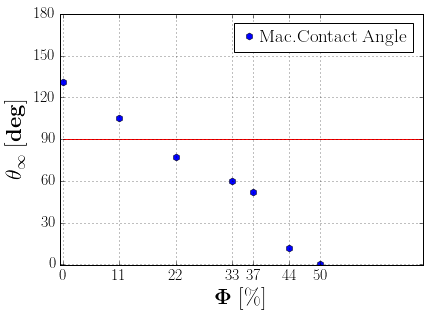

In [38]:
#Separate plot of macroscopic contact angle
plt.figure(figsize=(6.5,4.5), dpi=400)

# we mark the 90 deg. point with a line for the contact angle
zerox=range(71)
lineninety=71*[90]
plt.plot(zerox,lineninety,'r-')

#plt.plot(percentages2,degrees(theta_mac2_w),'-')
#plt.plot(percentages2,degrees(theta_mac2_m),'h-', color='orange')
plt.plot(percentages2,degrees(theta_mac2_s),'bh', label='Mac.Contact Angle',markersize=7)

#Interpolation until 50% using the next cell!
#plt.plot(xnew2, myfunction2_w(xnew2),'--')

#mytitle1=plt.suptitle('Macroscopic Cotact Angle',fontsize=20, fontweight='bold')

ylabel(r'$\mathbf{\theta_{\infty} \ [deg]}$',fontsize=22)
xlabel(r'$\mathbf{\Phi} \ [\%]$',fontsize=22)

first_legend = plt.legend(loc=0,handletextpad=0.1,borderpad=0.3,fontsize=19,markerscale=1)

xticks(percentages2,fontsize=16)
yticks([0,30,60,90,120,150,180],fontsize=16)
ylim(-0.5,180)
xlim(-0.5,70)

plt.grid()
plt.savefig('plt_theta_mac_phi.eps', bbox_inches='tight',dpi=400)

x= [-11.3129819  -13.78560348  10.63533498  -0.82389116   4.03569895
  53.91964014]
y= [ 2.29055432  1.83448902  1.34411686  1.04251921  0.90336496  0.25108628]


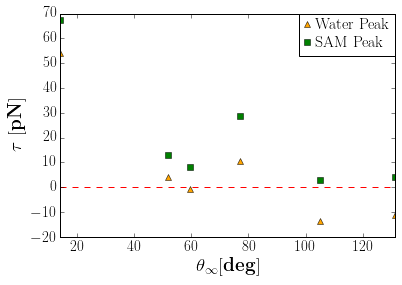

In [39]:
plt.figure(figsize=(6,4), dpi=400)

x2_w=sigma_w
y2_w=theta_mac_w

x2_m=sigma_m
y2_m=theta_mac_m

x2_s=sigma_s
y2_s=theta_mac_s
print "x=",x2_w
print "y=",y2_w


zerox=frange(min(degrees(y2_w)),max(degrees(y2_w)))
linezero=np.zeros(len(zerox))
plt.plot(zerox,linezero,'r--')

plt.plot(degrees(y2_w),x2_w,'^',color='orange',label="Water Peak")
#plt.plot(degrees(y2_w),x2_m,'h-',color='gray',label="GDS")
plt.plot(degrees(y2_w),x2_s,'s',color='green',label="SAM Peak")

xlim([min(degrees(y2_w)),max(degrees(y2_w))])
#ylim(-15,15)
xticks(fontsize=15)
yticks(fontsize=15)

#Labels with symbols
ylabel(r'$\mathbf{\tau \ [pN]}$',fontsize=19)
xlabel(r'$\mathbf{\theta_{\infty} [deg]}$',fontsize=19)

#Labels with names
#ylabel('Line tension [pN]',fontsize=19)
#xlabel('Mac. contact angle [deg]',fontsize=19)


#first_legend=plt.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
first_legend = plt.legend(loc=0,borderaxespad=0.,borderpad=0.3,fontsize=16,numpoints=1, markerscale=1.1,handlelength=0.4,handletextpad=0.3)


#plt.grid(which='major', axis='both') #(use grid if numbers are changed)

plt.show()
#plt.savefig('newview_theta_mac_tau2.jpg',bbox_extra_artists=(first_legend,mytitle,), bbox_inches='tight',dpi=1000)
#plt.savefig('newview_theta_mac_tau2.jpg',bbox_inches='tight',dpi=400)

x= [-11.3129819  -13.78560348  10.63533498  -0.82389116   4.03569895
  53.91964014]
y= [ 2.29055432  1.83448902  1.34411686  1.04251921  0.90336496  0.25108628]


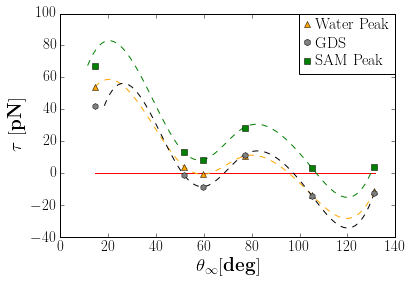

In [40]:
#NOW WE PLOT AGAIN TAU vs. THETA_MAC BUT INTERPOLATING THE DATA POINTS
plt.figure(figsize=(6,4), dpi=400)

x2_w=sigma_w
y2_w=theta_mac_w

x2_m=sigma_m
y2_m=theta_mac_m

x2_s=sigma_s
y2_s=theta_mac_s
print "x=",x2_w
print "y=",y2_w


zerox=frange(min(degrees(y2_w)),max(degrees(y2_w)))
linezero=np.zeros(len(zerox))
plt.plot(zerox,linezero,'r-')


# Interpolation of line tensions
xnew3_w = np.linspace(min(degrees(y2_w)), max(degrees(y2_w)), 100)
xnew3_m = np.linspace(min(degrees(y2_m)), max(degrees(y2_m)), 100)
xnew3_s = np.linspace(min(degrees(y2_s)), max(degrees(y2_s)), 100)

myfunction3_w = interp1d(degrees(y2_w), x2_w, kind='cubic')
myfunction3_m = interp1d(degrees(y2_m), x2_m, kind='cubic')
myfunction3_s = interp1d(degrees(y2_s), x2_s, kind='cubic')

plt.plot(xnew3_w, myfunction3_w(xnew3_w),'--',color='orange')
plt.plot(xnew3_m, myfunction3_m(xnew3_m),'--',color='black')
plt.plot(xnew3_s, myfunction3_s(xnew3_s),'--',color='green')

plt.plot(degrees(y2_w),x2_w,'^',color='orange',label="Water Peak")
plt.plot(degrees(y2_w),x2_m,'h',color='gray',label="GDS")
plt.plot(degrees(y2_w),x2_s,'s',color='green',label="SAM Peak")

#xlim([min(degrees(y2_w)),max(degrees(y2_w))])
#ylim(-20,15)
xticks(fontsize=15)
yticks(fontsize=15)

#Labels with symbols
ylabel(r'$\mathbf{\tau \ [pN]}$',fontsize=19)
xlabel(r'$\mathbf{\theta_{\infty} [deg]}$',fontsize=19)

#Labels with names
#ylabel('Line tension [pN]',fontsize=19)
#xlabel('Mac. contact angle [deg]',fontsize=19)


#first_legend=plt.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
first_legend = plt.legend(loc=0,borderaxespad=0.,borderpad=0.3,fontsize=16,numpoints=1, markerscale=1.1,handlelength=0.4,handletextpad=0.3)


#plt.grid(which='major', axis='both') #(use grid if numbers are changed)

plt.savefig('newview_theta_mac_tau2.jpg', bbox_inches='tight',dpi=400)

In [41]:
# Testing spicy.odr for errorbars in line tension and contact angle

# Define the function you want to fit against.:
def f_line(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

#Create a Model.:

linear = odr.Model(f_line)

#Create a Data or RealData instance.:

#mydata = Data(x, y, wd=1./power(sx,2), we=1./power(sy,2))

#or, when the actual covariances are known:

mydata = odr.RealData(array(x_w), array(y_w), sx=array(x_error_w), sy=array(y_error_w))

#Instantiate ODR with your data, model and initial parameter estimate.:

myodr = odr.ODR(mydata, linear, beta0=[0.14, 0.1])

#Run the fit.:

myoutput = myodr.run()

#Examine output.:

myoutput.pprint()

Beta: [-0.40295492  0.85340469]
Beta Std Error: [ 0.1424749   0.02904656]
Beta Covariance: [[  1.89861809e-04  -3.82903094e-05]
 [ -3.82903094e-05   7.89133380e-06]]
Residual Variance: 106.91511273
Inverse Condition #: 0.0254400505479
Reason(s) for Halting:
  Sum of squares convergence


-0.402954915679
0.853404687445
0.142474898704
0.0290465633573


<Container object of 3 artists>

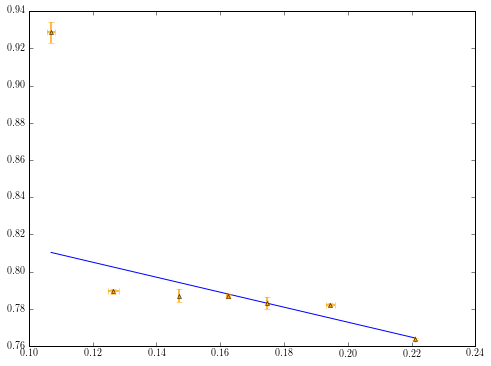

In [42]:
a, b = myoutput.beta
sa, sb = myoutput.sd_beta
print a
print b
print sa #slope??
print sb #intercept??

xp = np.linspace(min(x), max(x), 1000)
yp = a*xp+b
plt.plot(xp,yp)
plt.errorbar(x_w, y_w,xerr=x_error_w, yerr=y_error_w, fmt='^',color='orange',markersize=4,linewidth=1.5,label='Water Peak')

In [43]:
print type(x_error_w), x_error_w
print type(y_error_w), y_error_w

<type 'list'> [0.00013207196792453901, 0.0014326664740087738, 0.00029698285977867761, 0.00071513586565569263, 4.3194032610066218e-05, 0.0016096116000405467, 0.0012370171559332956]
<type 'list'> [0.00050592088265526169, 0.001030986724909144, 0.0032830433894444214, 0.0011607517719747107, 0.003372836845881176, 0.0013963321031209347, 0.0057529758630045511]


In [44]:
print type(x_w), x_w
print type(y_w), y_w

<type 'list'> [0.22107760583735489, 0.19458351980417921, 0.17455520294427052, 0.1624459532935241, 0.14692307494431497, 0.12650447868580633, 0.10697771675181741]
<type 'list'> [0.76381122667055601, 0.78227672332562725, 0.78308077422487898, 0.78693819476602622, 0.78702005803726083, 0.78948654707152088, 0.92859796351076229]


In [45]:
print intercepts_all_w

[-0.65920271097100647, -0.26064737123253112, 0.22474318217642336, 0.50404607273883661, 0.61897059396682863, 0.96864310130875009]


In [46]:
print slopes_all_w

[0.2146675882411001, 0.26158640374758657, -0.20180901291615566, 0.015633608346293872, -0.076578727675121541, -1.0231430767221401]


In [47]:
print i

5
